In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet

In [3]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

def load_time_series(subject, session, unit_id):
    #subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    subj_mat = hdf5storage.loadmat(f"/Volumes/Nexus/DBS/{subject}/Preprocessed Data/SpikeSorting/{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-2][time_point>time_data.min()+2]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)

# function to convert to superscript
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [4]:
#group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")
#group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/MGH BML/Sound-induced_STN_activity/manuscript/group_data_narrow_09082021.mat")
group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/stn_auditory/group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [5]:
def get_produced_phoneme(subject):
    #produced_phoneme = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_produced_phoneme.txt', sep='	', index_col='id')
    produced_phoneme = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_stimulus_phoneme.txt', sep='	', index_col='id')
    return produced_phoneme

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])
def find_full_3_trial(subj_table, timing_subj):
    good_trial = []
    subj_table = subj_table.dropna()
    subj_table = subj_table[subj_table['starts'] > timing_subj.min() + 4.5]
    subj_table = subj_table[subj_table['ends'] < timing_subj.max() - 4.5]
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0] == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [6]:
def get_model_result(input_df, reg_val):
    y = input_df['mean_fr']
    x = input_df.drop('mean_fr', axis=1)
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    model_result = pd.DataFrame(model.pvalues)
    model_result.columns =["pv"]
    model_result['sig'] = 0
    model_result.loc[model_result["pv"] < 0.05/reg_val, 'sig'] = 1
    #model_result.loc[model_result["pv"] < 0.05, 'sig'] = 1
    model_result['coef'] = model.params
    return np.sum((model.fittedvalues - y)**2), model_result

In [7]:
def get_matrix(input_df, neural_df, timing):
    input_df['t'] = 0
    input_df['g'] = 0
    input_df['s'] = 0
    input_df['v'] = 0
    input_df['i'] = 0
    input_df['u'] = 0
    input_df['a'] = 0
    input_df['syl1'] = 0
    input_df['syl2'] = 0
    input_df['syl3'] = 0

    for item in range(input_df.shape[0]):
        if input_df.iloc[item]['stim_y'] == 't':
            input_df['t'][item] = 1
        elif input_df.iloc[item]['stim_y'] == 'gh':
            input_df['g'][item] = 1
        elif input_df.iloc[item]['stim_y'] == 's':
            input_df['s'][item] = 1
        elif input_df.iloc[item]['stim_y'] == 'v':
            input_df['v'][item] = 1

        if input_df.iloc[item]['stim_x'] == 'ee':
            input_df['i'][item] = 1
        elif input_df.iloc[item]['stim_x'] == 'oo':
            input_df['u'][item] = 1
        elif input_df.iloc[item]['stim_x'] == 'ah':
            input_df['a'][item] = 1

        if input_df.iloc[item]['syl_id'] == 1:
            input_df['syl1'][item] = 1
        elif input_df.iloc[item]['syl_id'] == 2:
            input_df['syl2'][item] = 1
        elif input_df.iloc[item]['syl_id'] == 3:
            input_df['syl3'][item] = 1
        
    input_df['mean_fr'] = get_df(input_df['starts_y'], neural_df, timing, after=0.1, before=0.1).mean(axis=1)
    return input_df.iloc[:, -8:]


In [8]:
number_elec = 48
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)
cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()

subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix(subj_df_cue_speech, neural_df, timing)
xvals = np.linspace(-0.6, 0.6, 1200)


In [9]:
def get_matrix(input_df, neural_df, timing):
    input_df['t'] = 0
    input_df['g'] = 0
    input_df['s'] = 0
    input_df['v'] = 0
    input_df['i'] = 0
    input_df['u'] = 0
    input_df['a'] = 0
    input_df['syl1'] = 0
    input_df['syl2'] = 0
    input_df['syl3'] = 0

    for item in range(input_df.shape[0]):
        if input_df.iloc[item]['stim_y'] == 't':
            input_df['t'][item] = 1
        elif input_df.iloc[item]['stim_y'] == 'gh':
            input_df['g'][item] = 1
        elif input_df.iloc[item]['stim_y'] == 's':
            input_df['s'][item] = 1
        elif input_df.iloc[item]['stim_y'] == 'v':
            input_df['v'][item] = 1

        if input_df.iloc[item]['stim_x'] == 'ee':
            input_df['i'][item] = 1
        elif input_df.iloc[item]['stim_x'] == 'oo':
            input_df['u'][item] = 1
        elif input_df.iloc[item]['stim_x'] == 'ah':
            input_df['a'][item] = 1

        if input_df.iloc[item]['syl_id'] == 1:
            input_df['syl1'][item] = 1
        elif input_df.iloc[item]['syl_id'] == 2:
            input_df['syl2'][item] = 1
        elif input_df.iloc[item]['syl_id'] == 3:
            input_df['syl3'][item] = 1
        
    input_df['mean_fr'] = get_df(input_df['starts_y'], neural_df, timing, after=0.3, before=-0.1).mean(axis=1)
    return input_df.iloc[:, -11:]


In [10]:
def get_matrix2(input_df, neural_df, timing):
    input_df['t'] = 0
    input_df['g'] = 0
    input_df['s'] = 0
    input_df['i'] = 0
    input_df['u'] = 0
    input_df['syl2'] = 0
    input_df['syl3'] = 0

    for item in range(input_df.shape[0]):
        if input_df.iloc[item]['stim_y'] == 't':
            input_df['t'][item] = 1
        elif input_df.iloc[item]['stim_y'] == 'gh':
            input_df['g'][item] = 1
        elif input_df.iloc[item]['stim_y'] == 's':
            input_df['s'][item] = 1

        if input_df.iloc[item]['stim_x'] == 'ee':
            input_df['i'][item] = 1
        elif input_df.iloc[item]['stim_x'] == 'oo':
            input_df['u'][item] = 1

        if input_df.iloc[item]['syl_id'] == 2:
            input_df['syl2'][item] = 1
        elif input_df.iloc[item]['syl_id'] == 3:
            input_df['syl3'][item] = 1
        
    input_df['mean_fr'] = get_df(input_df['starts_y'], neural_df, timing, after=0.3, before=-0.1).mean(axis=1)
    return input_df.iloc[:, -8:]


In [11]:
subj_df_vowel

,starts,ends,duration,session_id,trial_id,syl_id,stim_x,stim_volume,type,stim_y
0,35520.421389,35520.695504,0.274115,1,1,1,ee,0,vowel,t
1,35520.994989,35521.217364,0.222375,1,1,2,oo,0,vowel,s
2,35521.454203,35521.723801,0.269598,1,1,3,ah,0,vowel,v
3,35525.952291,35526.175587,0.223295,1,2,1,ah,1,vowel,s
4,35526.396489,35526.670604,0.274115,1,2,2,ee,1,vowel,t
...,...,...,...,...,...,...,...,...,...,...
355,36091.308938,36091.590592,0.281655,1,119,2,ee,1,vowel,gh
356,36091.850278,36092.100486,0.250207,1,119,3,oo,1,vowel,v
357,36095.682722,36095.956837,0.274115,1,120,1,ee,1,vowel,t
358,36096.234845,36096.485053,0.250207,1,120,2,oo,1,vowel,v


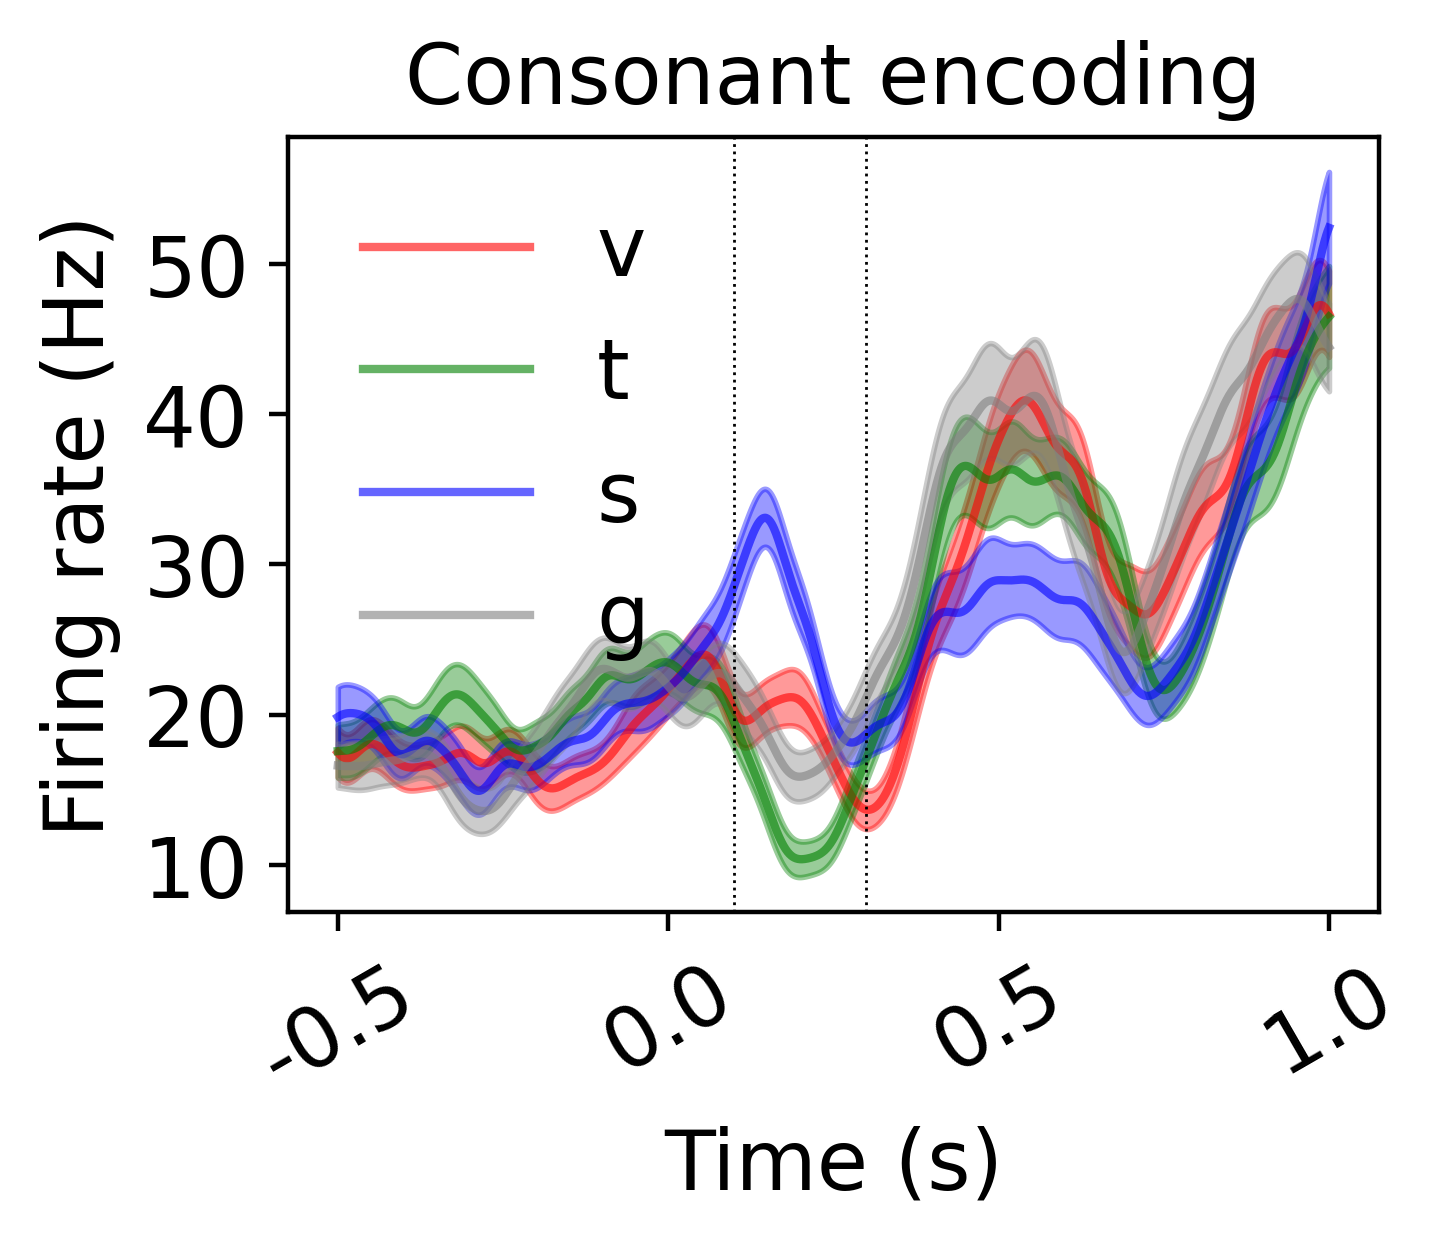

In [11]:
number_elec = 184
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

xvals = np.linspace(-0.5, 1, 1500)


fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3.5, 3), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

# Consonant
speech_onset_v = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "v"]['starts_y']
speech_onset_t = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "t"]['starts_y']
speech_onset_s = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "s"]['starts_y']
speech_onset_g = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "gh"]['starts_y']

spike_mat_v = get_df(speech_onset_v, neural_df, timing, after=1, before=0.5)
mean_v = np.nanmean(spike_mat_v, axis=0)
sem_v = nansem(spike_mat_v, axis=0)
axs.plot(xvals, mean_v, 'r', alpha=0.6, label='v')
axs.fill_between(xvals, mean_v-sem_v, mean_v+sem_v, color='r', alpha=0.4)

spike_mat_t = get_df(speech_onset_t, neural_df, timing, after=1, before=0.5)
mean_t = np.nanmean(spike_mat_t, axis=0)
sem_t = nansem(spike_mat_t, axis=0)
axs.plot(xvals, mean_t, 'g', alpha=0.6, label='t')
axs.fill_between(xvals, mean_t-sem_t, mean_t+sem_t, color='g', alpha=0.4)

spike_mat_s = get_df(speech_onset_s, neural_df, timing, after=1, before=0.5)
mean_s = np.nanmean(spike_mat_s, axis=0)
sem_s = nansem(spike_mat_s, axis=0)
axs.plot(xvals, mean_s, 'b', alpha=0.6, label='s')
axs.fill_between(xvals, mean_s-sem_s, mean_s+sem_s, color='b', alpha=0.4)

spike_mat_g = get_df(speech_onset_g, neural_df, timing, after=1, before=0.5)
mean_g = np.nanmean(spike_mat_g, axis=0)
sem_g = nansem(spike_mat_g, axis=0)
axs.plot(xvals, mean_g, 'grey', alpha=0.6, label='g')
axs.fill_between(xvals, mean_g-sem_g, mean_g+sem_g, color='grey', alpha=0.4)

axs.axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs.axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
axs.set_xlabel("Time (s)", fontsize=15)
axs.set_ylabel("Firing rate (Hz)", fontsize=15)
axs.set_title("Consonant encoding", fontsize=15)
axs.set_xticklabels([round(item, 2) for item in axs.get_xticks()], fontsize=15, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=15)
axs.legend(frameon=0, fontsize=15)
#plt.savefig("../plots/fig2b1.svg", format = 'svg', dpi=200);
plt.show();
#axs.legend(frameon=0, fontsize=20, ncol=2, markerscale=0.1, bbox_to_anchor=(0.5, 0.42), 
#           labelspacing=0.1, columnspacing=0.2, numpoints=0.1);

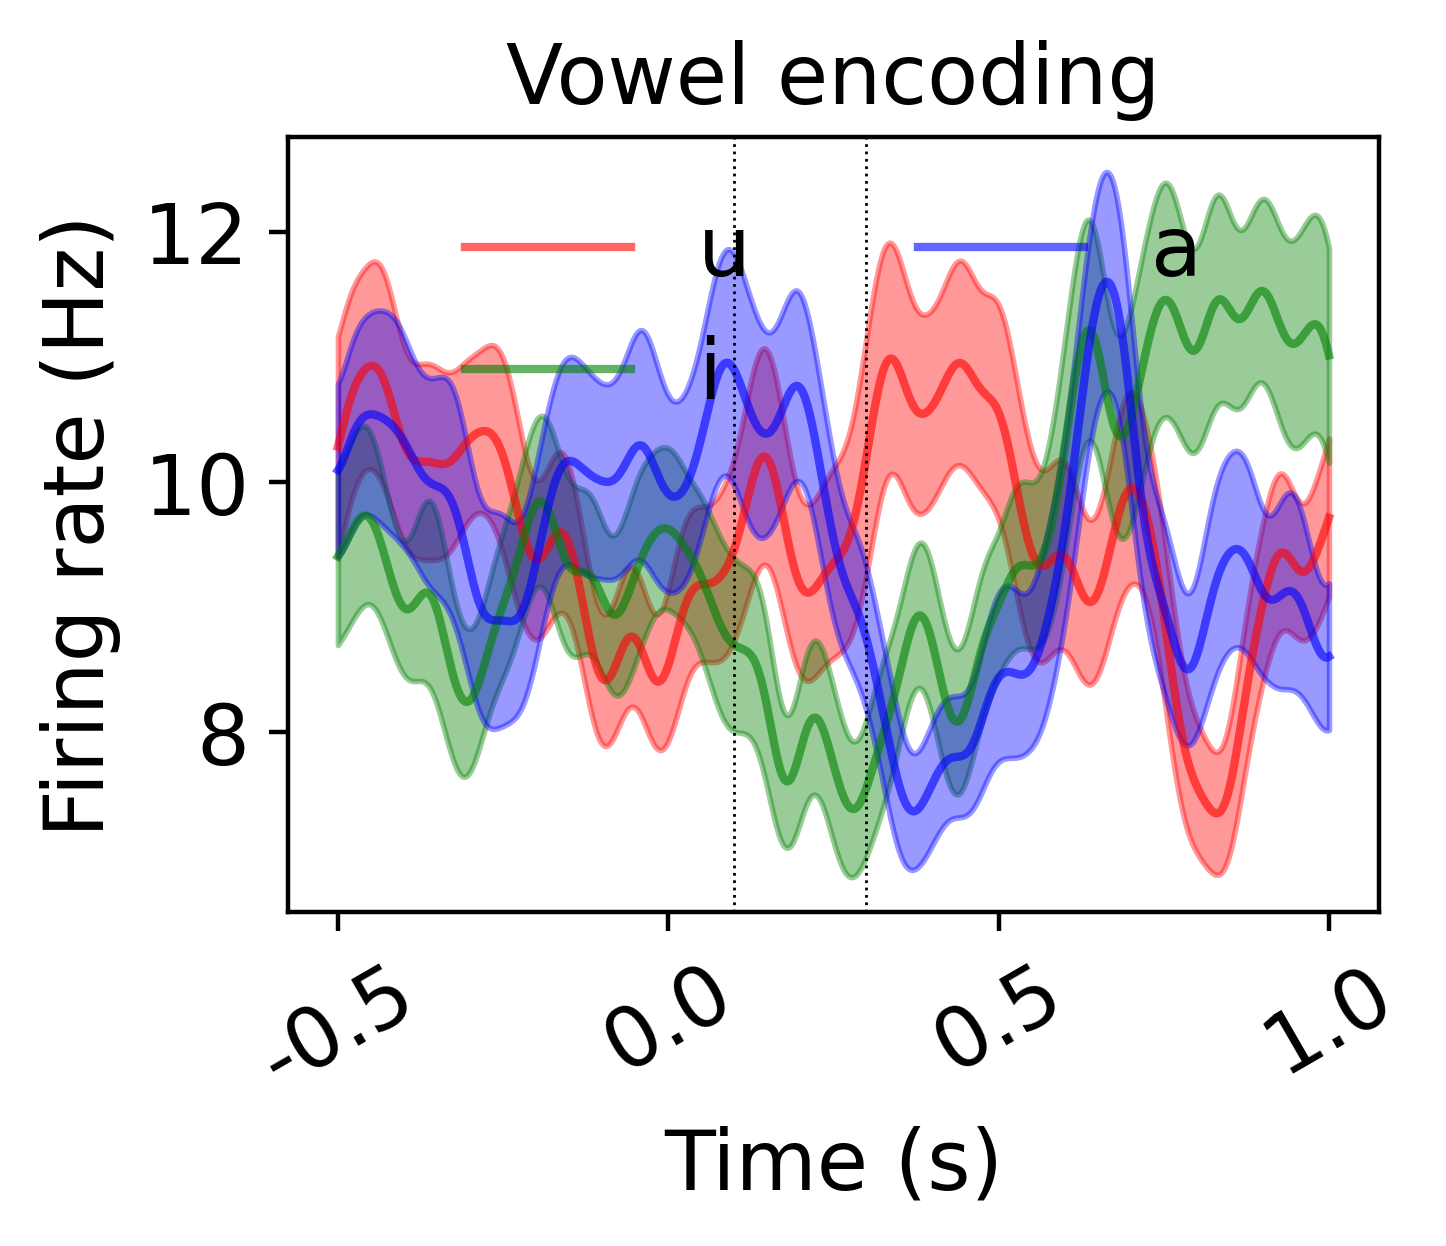

In [22]:
number_elec = 30
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

xvals = np.linspace(-0.5, 1, 1500)


fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3.5, 3), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

# Vowel
speech_onset_u = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "oo"]['starts_y']
speech_onset_i = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "ee"]['starts_y']
speech_onset_a = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "ah"]['starts_y']

spike_mat_u = get_df(speech_onset_u, neural_df, timing, after=1, before=0.5)
mean_u = np.nanmean(spike_mat_u, axis=0)
sem_u = nansem(spike_mat_u, axis=0)
axs.plot(xvals, mean_u, 'r', alpha=0.6, label='u')
axs.fill_between(xvals, mean_u-sem_u, mean_u+sem_u, color='r', alpha=0.4)

spike_mat_i = get_df(speech_onset_i, neural_df, timing, after=1, before=0.5)
mean_i = np.nanmean(spike_mat_i, axis=0)
sem_i = nansem(spike_mat_i, axis=0)
axs.plot(xvals, mean_i, 'g', alpha=0.6, label='i')
axs.fill_between(xvals, mean_i-sem_i, mean_i+sem_i, color='g', alpha=0.4)

spike_mat_a = get_df(speech_onset_a, neural_df, timing, after=1, before=0.5)
mean_a = np.nanmean(spike_mat_a, axis=0)
sem_a = nansem(spike_mat_a, axis=0)
axs.plot(xvals, mean_a, 'b', alpha=0.6, label='a')
axs.fill_between(xvals, mean_a-sem_a, mean_a+sem_a, color='b', alpha=0.4)

axs.axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs.axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
axs.set_xlabel("Time (s)", fontsize=15)
axs.set_ylabel("Firing rate (Hz)", fontsize=15)
axs.set_title("Vowel encoding", fontsize=15)
axs.set_xticklabels([round(item, 2) for item in axs.get_xticks()], fontsize=15, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=15)
axs.legend(frameon=0, fontsize=15, ncol=2)
plt.savefig("../plots/fig2b2.svg", format = 'svg', dpi=200);

#axs.legend(frameon=0, fontsize=20, ncol=3, markerscale=0.1, bbox_to_anchor=(0.7, 0.6), 
#           labelspacing=0.1, columnspacing=0.2, numpoints=0.1);

0 Text(0, 0, 'syl1')
1 Text(0, 0, 'syl2')
2 Text(0, 0, 'syl3')


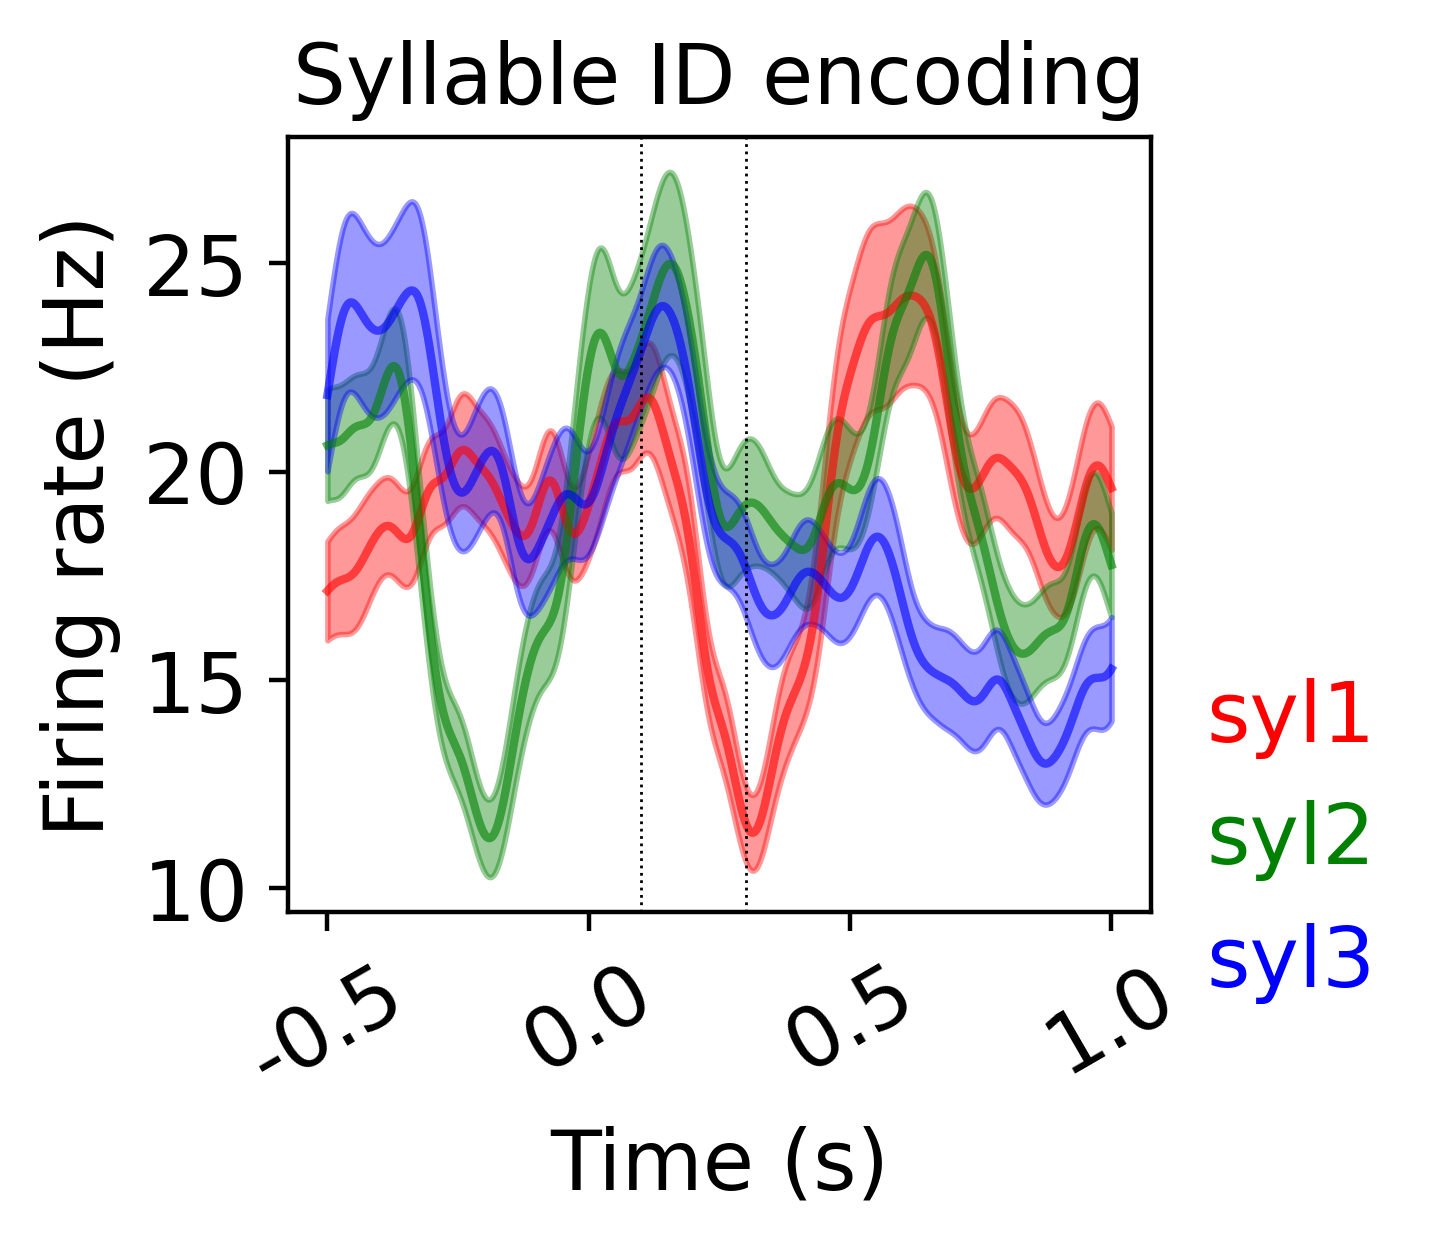

In [41]:
number_elec = 26
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

xvals = np.linspace(-0.5, 1, 1500)


fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3.5, 3), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

# Syl ID
speech_onset_1 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 1]['starts_y']
speech_onset_2 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 2]['starts_y']
speech_onset_3 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 3]['starts_y']

spike_mat_1 = get_df(speech_onset_1, neural_df, timing, after=1, before=0.5)
mean_1 = np.nanmean(spike_mat_1, axis=0)
sem_1 = nansem(spike_mat_1, axis=0)
axs.plot(xvals, mean_1, 'r', alpha=0.6, label='syl1')
axs.fill_between(xvals, mean_1-sem_1, mean_1+sem_1, color='r', alpha=0.4)

spike_mat_2 = get_df(speech_onset_2, neural_df, timing, after=1, before=0.5)
mean_2 = np.nanmean(spike_mat_2, axis=0)
sem_2 = nansem(spike_mat_2, axis=0)
axs.plot(xvals, mean_2, 'g', alpha=0.6, label='syl2')
axs.fill_between(xvals, mean_2-sem_2, mean_2+sem_2, color='g', alpha=0.4)

spike_mat_3 = get_df(speech_onset_3, neural_df, timing, after=1, before=0.5)
mean_3 = np.nanmean(spike_mat_3, axis=0)
sem_3 = nansem(spike_mat_3, axis=0)
axs.plot(xvals, mean_3, 'b', alpha=0.6, label='syl3')
axs.fill_between(xvals, mean_3-sem_3, mean_3+sem_3, color='b', alpha=0.4)

axs.axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs.axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
axs.set_xlabel("Time (s)", fontsize=15)
axs.set_ylabel("Firing rate (Hz)", fontsize=15)
axs.set_title("Syllable ID encoding", fontsize=15)
axs.set_xticklabels([round(item, 2) for item in axs.get_xticks()], fontsize=15, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=15)
legend = axs.legend(frameon=0, fontsize=15, bbox_to_anchor=(0.9, 0.5), handlelength=0)
color_l = ['r', 'g', 'b']
for n, text in enumerate(legend.texts):
    text.set_color(color_l[n])
#plt.savefig("../plots/fig2b3.svg", format = 'svg', dpi=200);

plt.show();

#axs.legend(frameon=0, fontsize=20, ncol=2, markerscale=0.1, bbox_to_anchor=(0.41, 0.6), 
#           labelspacing=0.1, columnspacing=0.2, numpoints=0.1);

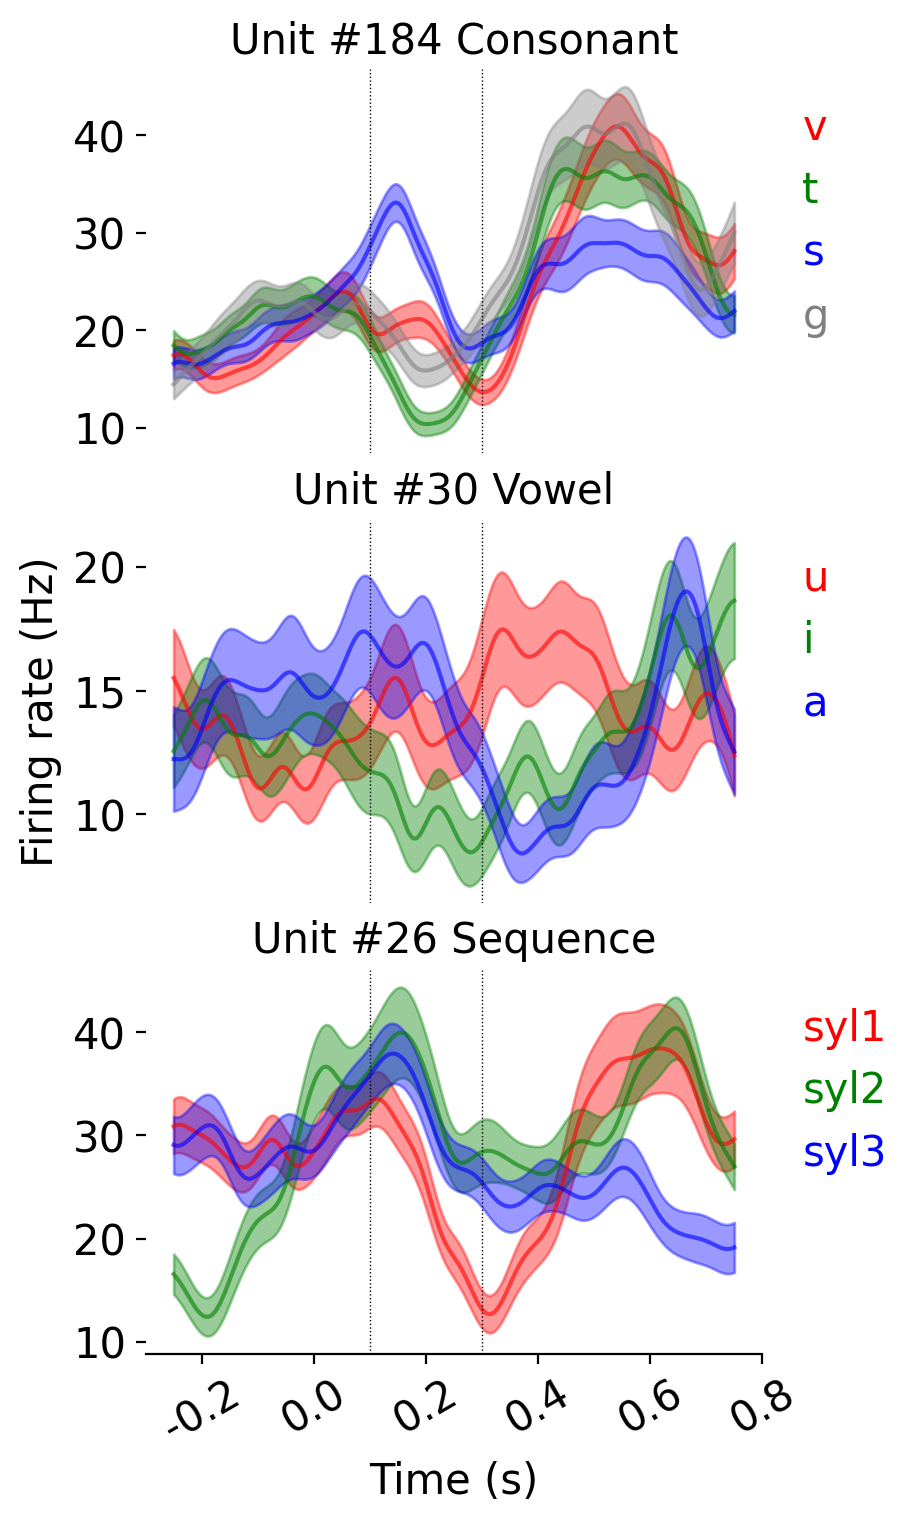

In [22]:

fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(4.5, 7.5), dpi=200)
fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[1].patch.set_alpha(0)
axs[2].patch.set_alpha(0)
xvals = np.linspace(-0.25, 0.75, 1000)


number_elec = 184
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

# Consonant
speech_onset_v = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "v"]['starts_y']
speech_onset_t = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "t"]['starts_y']
speech_onset_s = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "s"]['starts_y']
speech_onset_g = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "gh"]['starts_y']

spike_mat_v = get_df(speech_onset_v, neural_df, timing, after=0.75, before=0.25)
mean_v = np.nanmean(spike_mat_v, axis=0)
sem_v = nansem(spike_mat_v, axis=0)
axs[0].plot(xvals, mean_v, 'r', alpha=0.6, label='v')
axs[0].fill_between(xvals, mean_v-sem_v, mean_v+sem_v, color='r', alpha=0.4)

spike_mat_t = get_df(speech_onset_t, neural_df, timing, after=0.75, before=0.25)
mean_t = np.nanmean(spike_mat_t, axis=0)
sem_t = nansem(spike_mat_t, axis=0)
axs[0].plot(xvals, mean_t, 'g', alpha=0.6, label='t')
axs[0].fill_between(xvals, mean_t-sem_t, mean_t+sem_t, color='g', alpha=0.4)

spike_mat_s = get_df(speech_onset_s, neural_df, timing, after=0.75, before=0.25)
mean_s = np.nanmean(spike_mat_s, axis=0)
sem_s = nansem(spike_mat_s, axis=0)
axs[0].plot(xvals, mean_s, 'b', alpha=0.6, label='s')
axs[0].fill_between(xvals, mean_s-sem_s, mean_s+sem_s, color='b', alpha=0.4)

spike_mat_g = get_df(speech_onset_g, neural_df, timing, after=0.75, before=0.25)
mean_g = np.nanmean(spike_mat_g, axis=0)
sem_g = nansem(spike_mat_g, axis=0)
axs[0].plot(xvals, mean_g, 'grey', alpha=0.6, label='g')
axs[0].fill_between(xvals, mean_g-sem_g, mean_g+sem_g, color='grey', alpha=0.4)

axs[0].axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs[0].axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
#axs[0].set_xlabel("Time (s)", fontsize=15)
#axs[0].set_ylabel("Firing rate (Hz)", fontsize=15)
axs[0].set_title(f"Unit #{number_elec} Consonant", fontsize=15)
#axs[0].set_xticklabels([round(item, 2) for item in axs[0].get_xticks()], fontsize=15, rotation=30)
axs[0].set_yticklabels(axs[0].get_yticks().astype(int), fontsize=15)
axs[0].set_xticks([])
legend_1 = axs[0].legend(frameon=0, fontsize=15, bbox_to_anchor=(0.95, 1), handlelength=0)
color_l = ['r', 'g', 'b', 'grey']
for n, text in enumerate(legend_1.texts):
    text.set_color(color_l[n])
#plt.savefig("../plots/fig2b1.svg", format = 'svg', dpi=200);




number_elec = 30
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

# Vowel
speech_onset_u = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "oo"]['starts_y']
speech_onset_i = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "ee"]['starts_y']
speech_onset_a = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "ah"]['starts_y']

spike_mat_u = get_df(speech_onset_u, neural_df, timing, after=0.75, before=0.25)
mean_u = np.nanmean(spike_mat_u, axis=0)
sem_u = nansem(spike_mat_u, axis=0)
axs[1].plot(xvals, mean_u, 'r', alpha=0.6, label='u')
axs[1].fill_between(xvals, mean_u-sem_u, mean_u+sem_u, color='r', alpha=0.4)

spike_mat_i = get_df(speech_onset_i, neural_df, timing, after=0.75, before=0.25)
mean_i = np.nanmean(spike_mat_i, axis=0)
sem_i = nansem(spike_mat_i, axis=0)
axs[1].plot(xvals, mean_i, 'g', alpha=0.6, label='i')
axs[1].fill_between(xvals, mean_i-sem_i, mean_i+sem_i, color='g', alpha=0.4)

spike_mat_a = get_df(speech_onset_a, neural_df, timing, after=0.75, before=0.25)
mean_a = np.nanmean(spike_mat_a, axis=0)
sem_a = nansem(spike_mat_a, axis=0)
axs[1].plot(xvals, mean_a, 'b', alpha=0.6, label='a')
axs[1].fill_between(xvals, mean_a-sem_a, mean_a+sem_a, color='b', alpha=0.4)

axs[1].axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs[1].axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
#axs[1].set_xlabel("Time (s)", fontsize=15)
axs[1].set_ylabel("Firing rate (Hz)", fontsize=15)
axs[1].set_title(f"Unit #{number_elec} Vowel", fontsize=15)
#axs[1].set_xticklabels([round(item, 2) for item in axs[1].get_xticks()], fontsize=15, rotation=30)
axs[1].set_yticklabels(axs[1].get_yticks().astype(int), fontsize=15)
legend_2 = axs[1].legend(frameon=0, fontsize=15, bbox_to_anchor=(0.95, 1), handlelength=0)
color_l = ['r', 'g', 'b']
for n, text in enumerate(legend_2.texts):
    text.set_color(color_l[n])
axs[1].set_xticks([])

#axs.legend(frameon=0, fontsize=20, ncol=3, markerscale=0.1, bbox_to_anchor=(0.7, 0.6), 
#           labelspacing=0.1, columnspacing=0.2, numpoints=0.1);





number_elec = 26
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

# Syl ID
speech_onset_1 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 1]['starts_y']
speech_onset_2 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 2]['starts_y']
speech_onset_3 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 3]['starts_y']

spike_mat_1 = get_df(speech_onset_1, neural_df, timing, after=0.75, before=0.25)
mean_1 = np.nanmean(spike_mat_1, axis=0)
sem_1 = nansem(spike_mat_1, axis=0)
axs[2].plot(xvals, mean_1, 'r', alpha=0.6, label='syl1')
axs[2].fill_between(xvals, mean_1-sem_1, mean_1+sem_1, color='r', alpha=0.4)

spike_mat_2 = get_df(speech_onset_2, neural_df, timing, after=0.75, before=0.25)
mean_2 = np.nanmean(spike_mat_2, axis=0)
sem_2 = nansem(spike_mat_2, axis=0)
axs[2].plot(xvals, mean_2, 'g', alpha=0.6, label='syl2')
axs[2].fill_between(xvals, mean_2-sem_2, mean_2+sem_2, color='g', alpha=0.4)

spike_mat_3 = get_df(speech_onset_3, neural_df, timing, after=0.75, before=0.25)
mean_3 = np.nanmean(spike_mat_3, axis=0)
sem_3 = nansem(spike_mat_3, axis=0)
axs[2].plot(xvals, mean_3, 'b', alpha=0.6, label='syl3')
axs[2].fill_between(xvals, mean_3-sem_3, mean_3+sem_3, color='b', alpha=0.4)

axs[2].axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs[2].axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
axs[2].set_xlabel("Time (s)", fontsize=15)
#axs.set_ylabel("Firing rate (Hz)", fontsize=15)
axs[2].set_title(f"Unit #{number_elec} Sequence", fontsize=15)
axs[2].set_xticklabels([round(item, 2) for item in axs[2].get_xticks()], fontsize=15, rotation=30)
axs[2].set_yticklabels(axs[2].get_yticks().astype(int), fontsize=15)
legend_3 = axs[2].legend(frameon=0, fontsize=15, bbox_to_anchor=(0.95, 1), handlelength=0)
color_l = ['r', 'g', 'b']
for n, text in enumerate(legend_3.texts):
    text.set_color(color_l[n])

    
sns.despine(ax=axs[0], top=True, right=True, left=True, bottom=True)
sns.despine(ax=axs[1], top=True, right=True, left=True, bottom=True)
sns.despine(ax=axs[2], top=True, right=True, left=True, bottom=False)




plt.show();

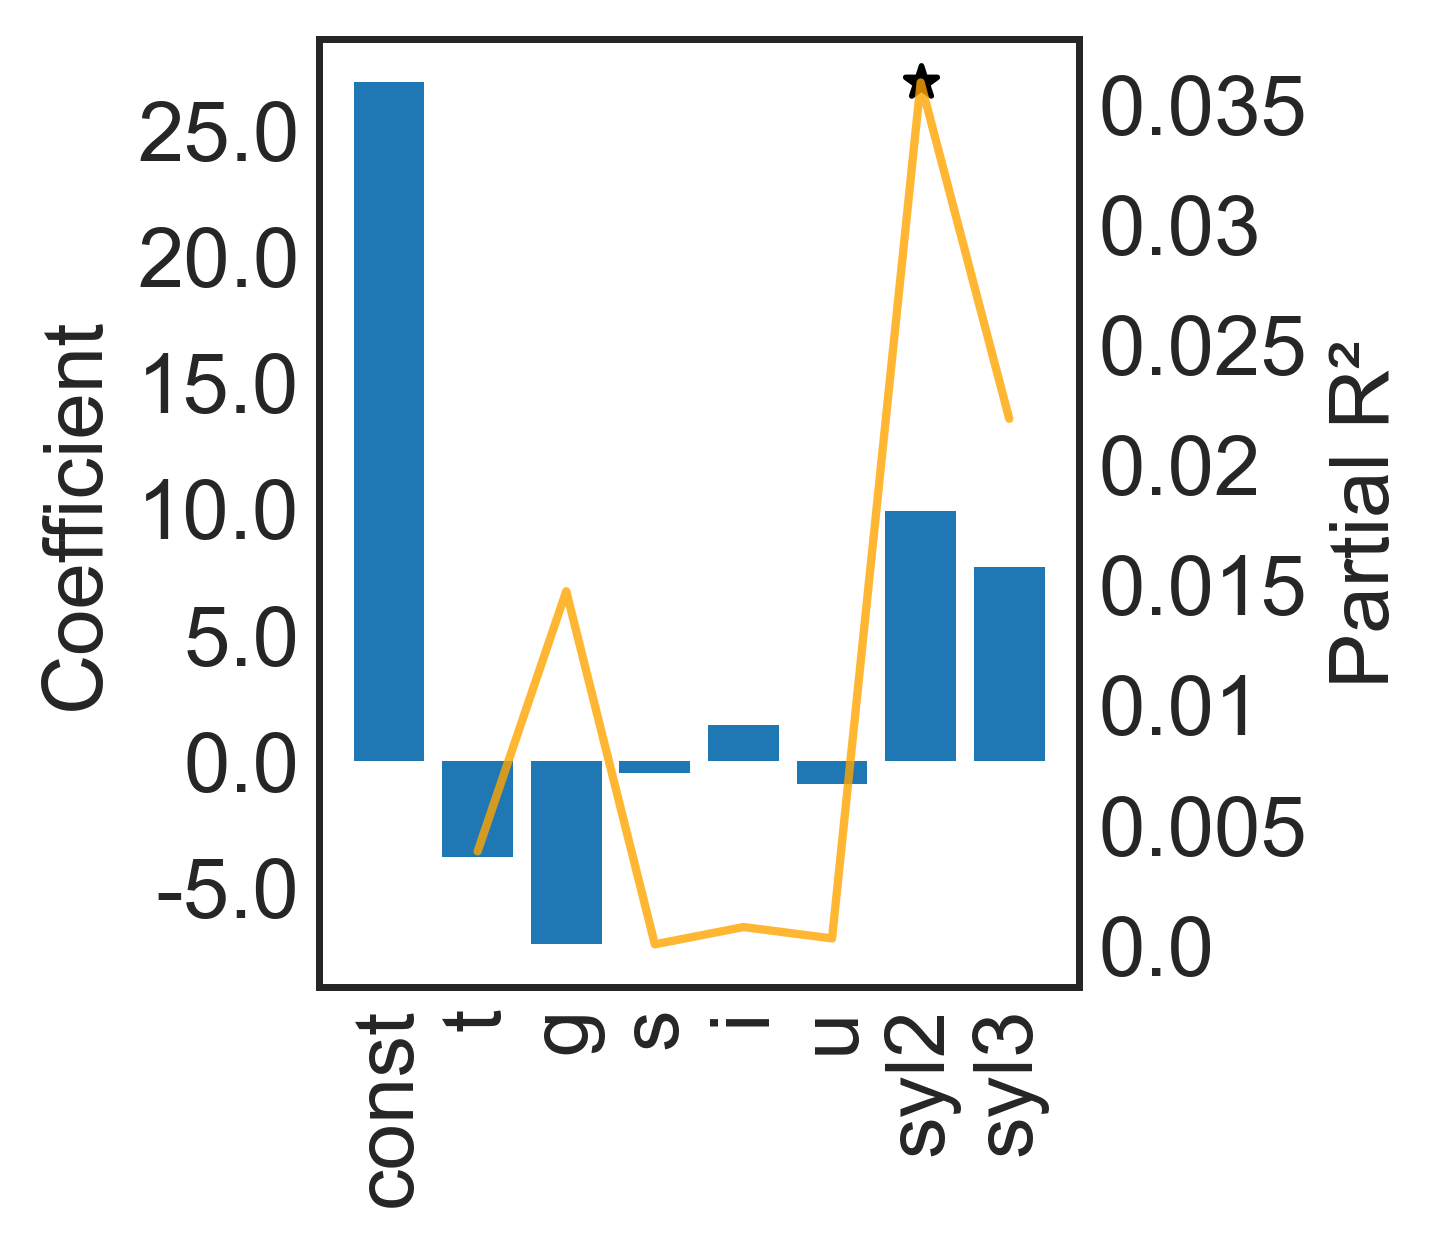

In [10]:
number_elec = 26
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1))
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1))
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1))
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1))
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1))
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1))
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1))
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3.5, 3), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)
axs.bar(x=model_full.index, height=model_full['coef'])

ax2 = axs.twinx()
ax2.patch.set_alpha(0)
ax2.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k')
axs.set_ylabel("Coefficient", fontsize=15)
ax2.set_ylabel(f"Partial R{get_super('2')}", fontsize=15)
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=15)
ax2.set_yticklabels([round(item, 3) for item in ax2.get_yticks()], fontsize=15)
axs.set_xticklabels(model_full.index, rotation=90, fontsize=15);
plt.savefig("../plots/fig2b6.svg", format = 'svg', dpi=200);


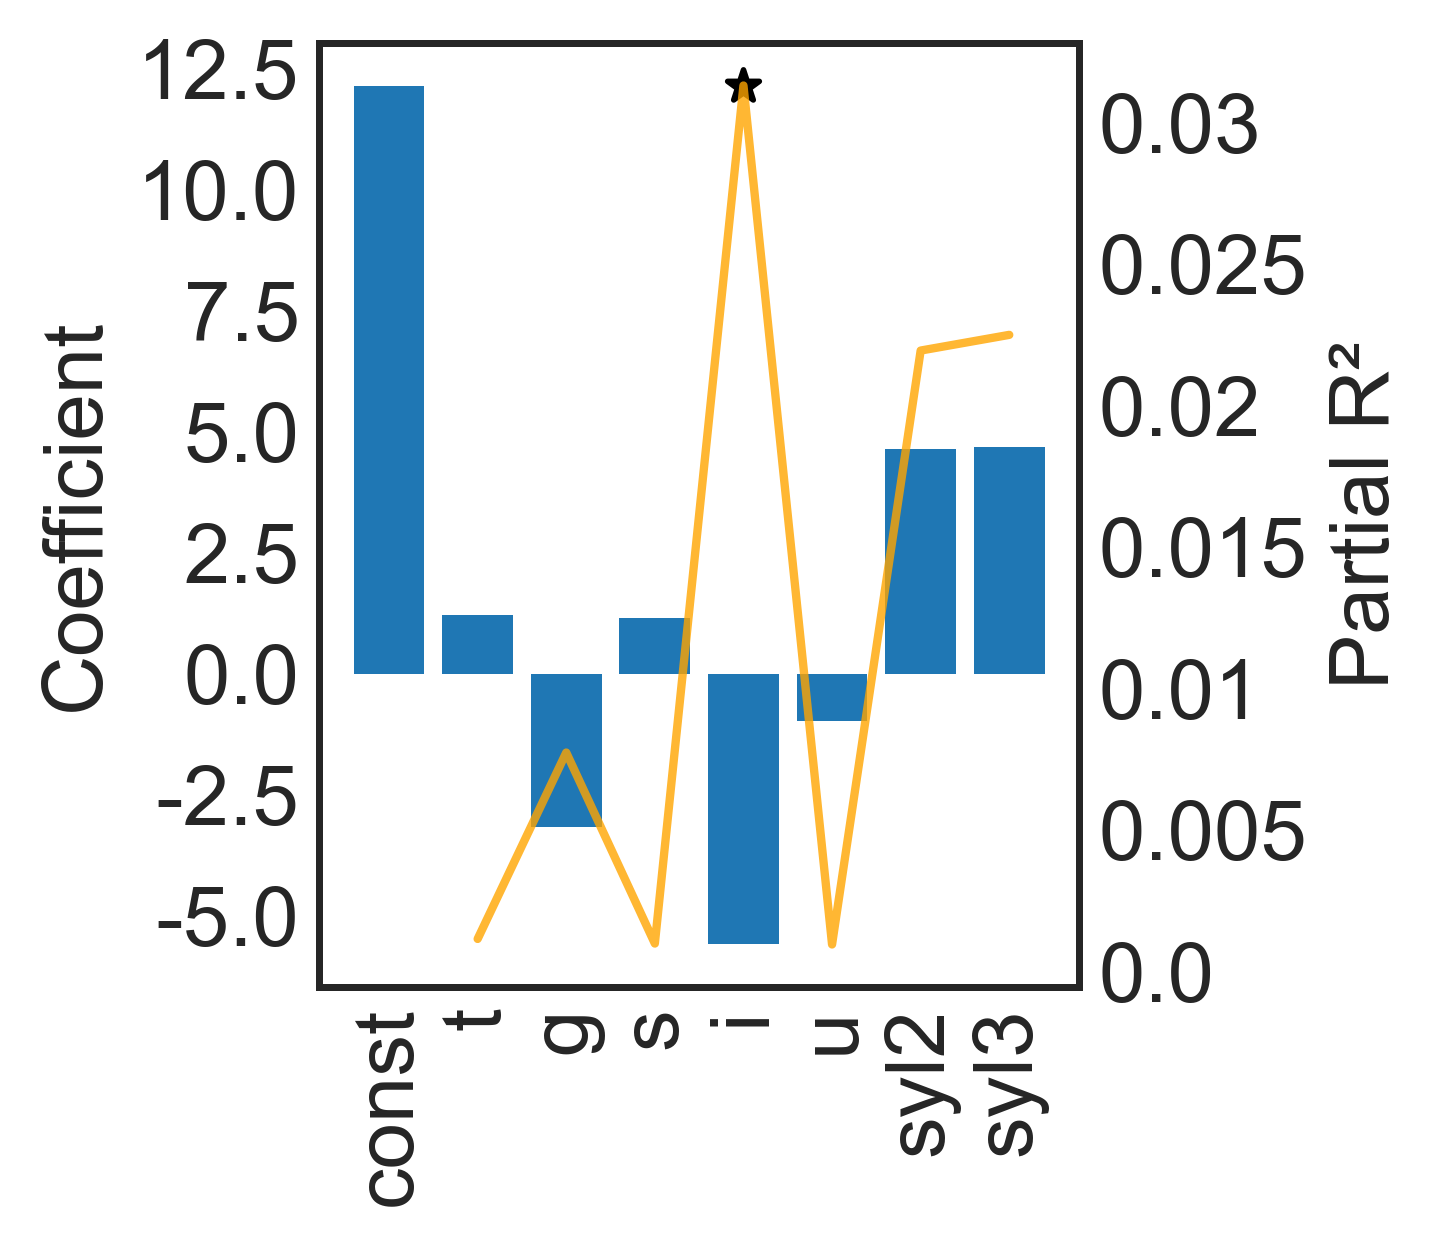

In [11]:
number_elec = 30
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1))
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1))
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1))
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1))
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1))
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1))
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1))
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3.5, 3), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)
axs.bar(x=model_full.index, height=model_full['coef'])

ax2 = axs.twinx()
ax2.patch.set_alpha(0)
ax2.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k')
axs.set_ylabel("Coefficient", fontsize=15)
ax2.set_ylabel(f"Partial R{get_super('2')}", fontsize=15)
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=15)
ax2.set_yticklabels([round(item, 3) for item in ax2.get_yticks()], fontsize=15)
axs.set_xticklabels(model_full.index, rotation=90, fontsize=15);
plt.savefig("../plots/fig2b5.svg", format = 'svg', dpi=200);


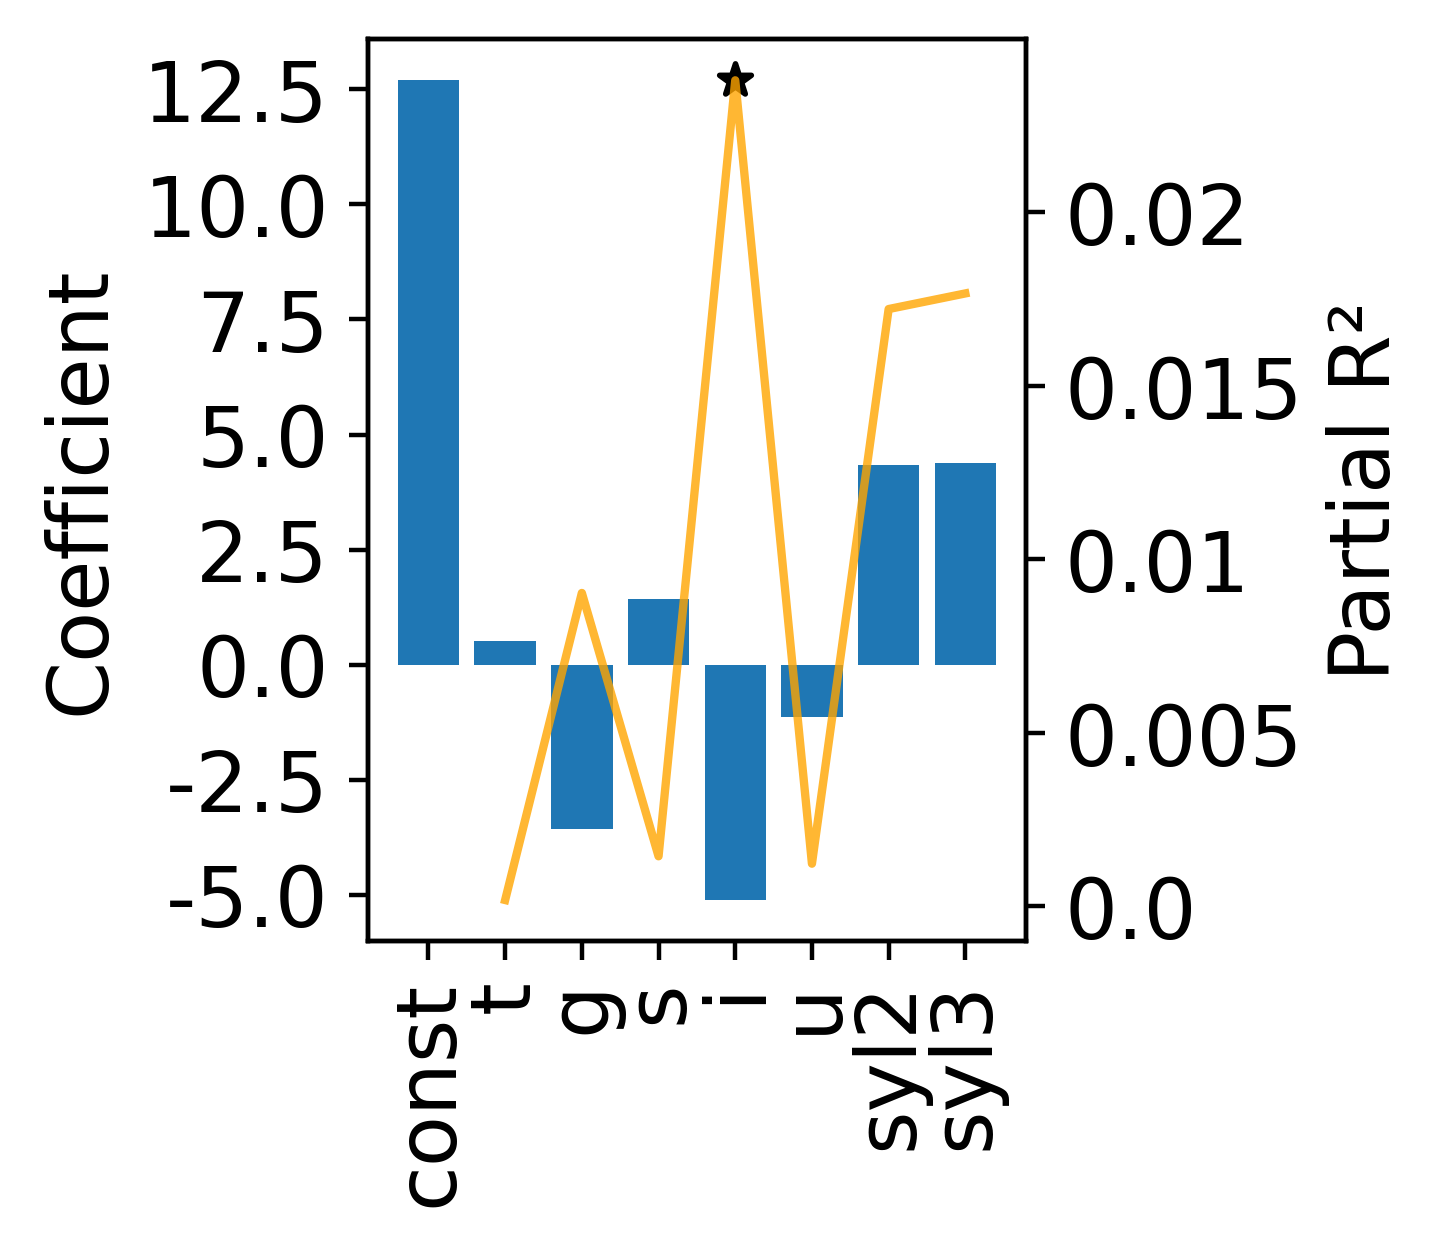

In [75]:
number_elec = 30
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para, reg_val=3)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1), reg_val=3)
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1), reg_val=3)
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1), reg_val=3)
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1), reg_val=3)
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1), reg_val=3)
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1), reg_val=3)
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1), reg_val=3)
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3.5, 3), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)
axs.bar(x=model_full.index, height=model_full['coef'])

ax2 = axs.twinx()
ax2.patch.set_alpha(0)
ax2.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k')
axs.set_ylabel("Coefficient", fontsize=15)
ax2.set_ylabel(f"Partial R{get_super('2')}", fontsize=15)
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=15)
ax2.set_yticklabels([round(item, 3) for item in ax2.get_yticks()], fontsize=15)
axs.set_xticklabels(model_full.index, rotation=90, fontsize=15);
plt.savefig("../plots/fig2b5.svg", format = 'svg', dpi=200);


In [68]:
model_full

,pv,sig,coef,pR2
const,1.130069e-07,1,12.698172,0.000000
t,8.245356e-01,0,0.510362,0.000184
g,1.192496e-01,0,-3.580886,0.009032
s,5.342146e-01,0,1.435277,0.001443
i,1.112603e-02,1,-5.117217,0.023806
u,5.660287e-01,0,-1.138746,0.001231
syl2,3.114613e-02,1,4.332658,0.017214
syl3,2.900239e-02,1,4.378099,0.017664


In [71]:
1.112603e-02 - 0.05/3

-0.005540636666666666

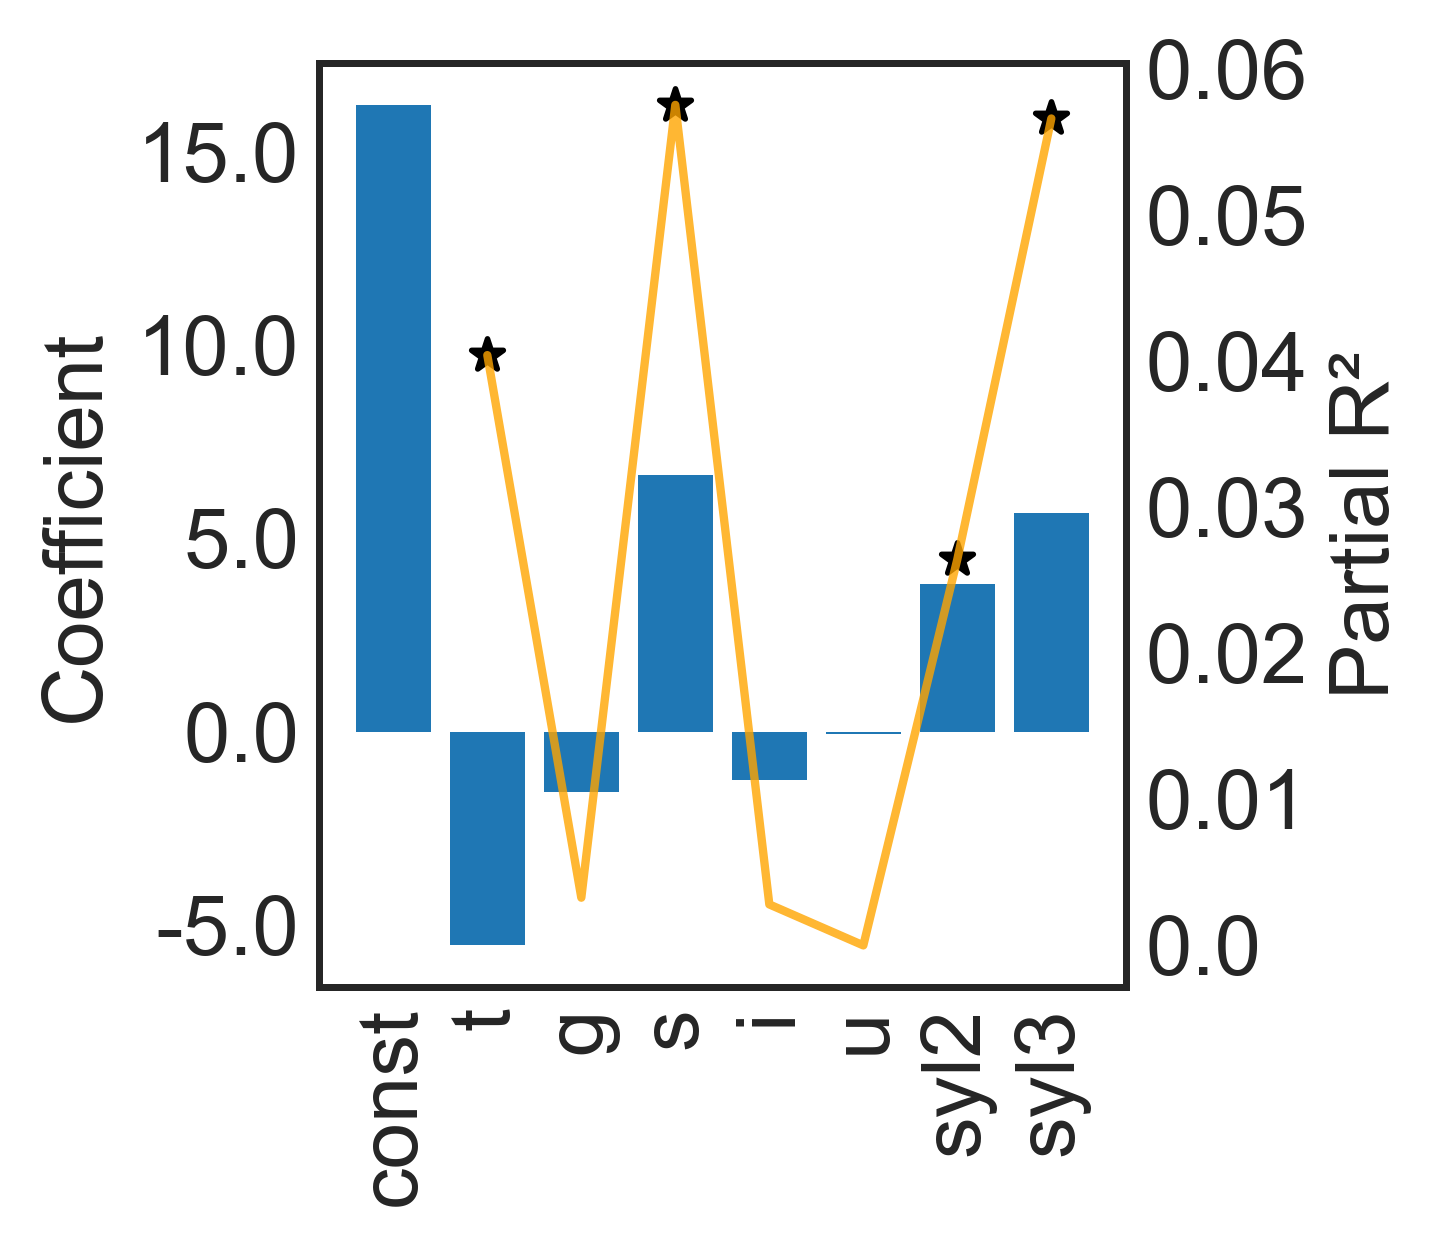

In [12]:
number_elec = 184
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1))
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1))
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1))
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1))
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1))
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1))
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1))
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3.5, 3), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)
axs.bar(x=model_full.index, height=model_full['coef'])

ax2 = axs.twinx()
ax2.patch.set_alpha(0)
ax2.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k')
axs.set_ylabel("Coefficient", fontsize=15)
ax2.set_ylabel(f"Partial R{get_super('2')}", fontsize=15)
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=15)
ax2.set_yticklabels([round(item, 3) for item in ax2.get_yticks()], fontsize=15)
axs.set_xticklabels(model_full.index, rotation=90, fontsize=15);
plt.savefig("../plots/fig2b4.svg", format = 'svg', dpi=200);


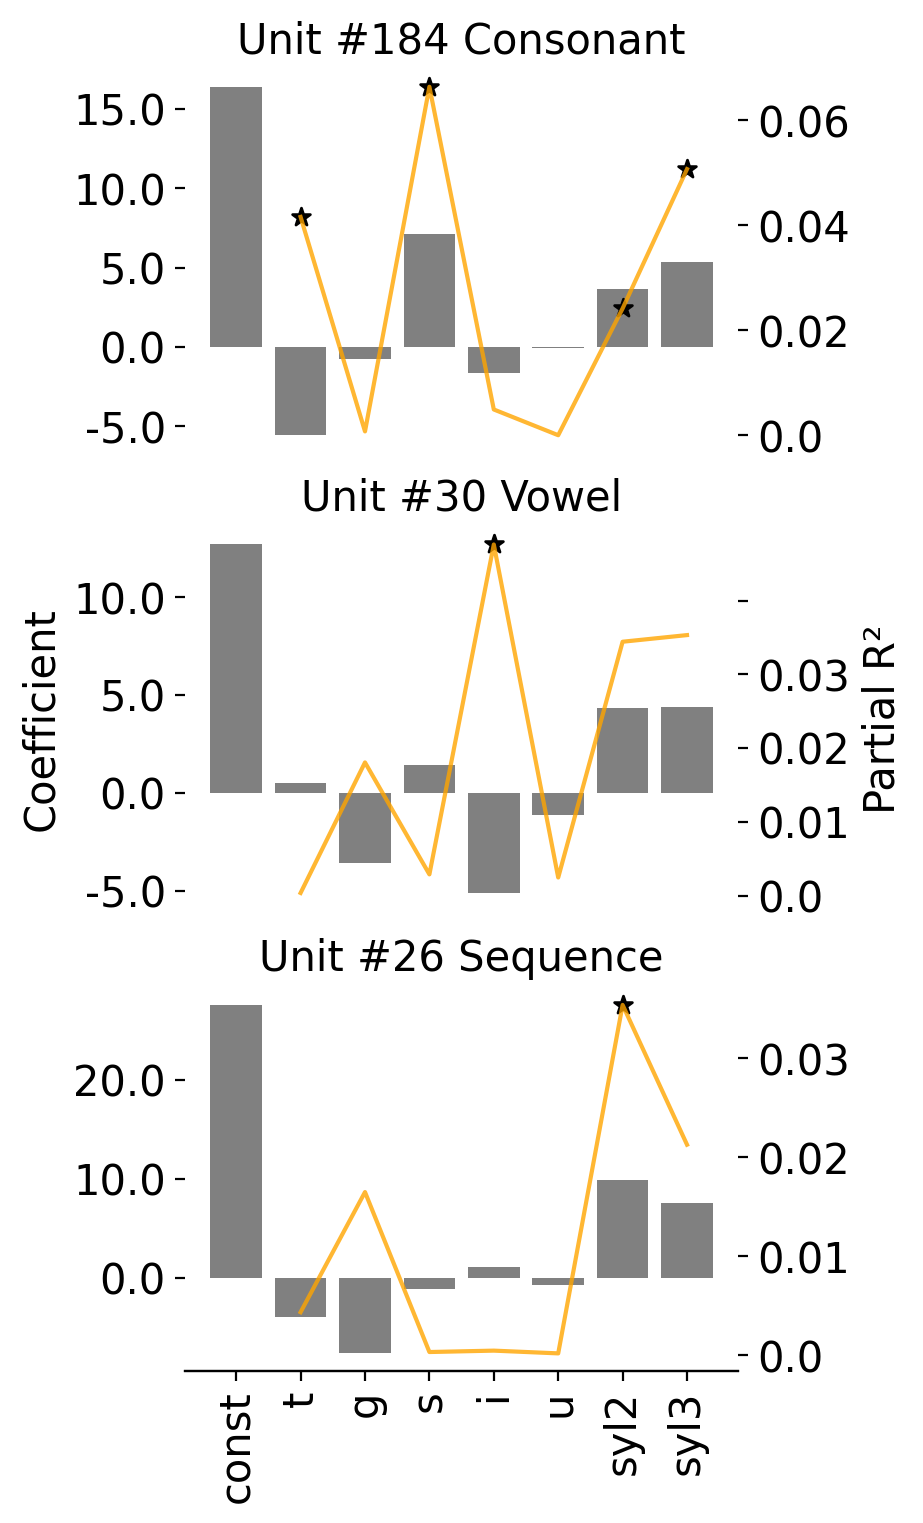

In [21]:

fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(4.5, 7.5), dpi=200)
fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[1].patch.set_alpha(0)
axs[2].patch.set_alpha(0)
xvals = np.linspace(-0.5, 1, 1500)






number_elec = 184
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para, reg_val=4)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1), reg_val=4)
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1), reg_val=4)
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1), reg_val=4)
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1), reg_val=4)
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1), reg_val=4)
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1), reg_val=4)
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1), reg_val=4)
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3


axs[0].bar(x=model_full.index, height=model_full['coef'], color='grey')

ax2_0 = axs[0].twinx()
ax2_0.patch.set_alpha(0)
ax2_0.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2_0.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k', s=45)
#axs[0].set_ylabel("Coefficient", fontsize=15)
#ax2_0.set_ylabel(f"Partial R{get_super('2')}", fontsize=15)
axs[0].set_yticklabels([round(item, 2) for item in axs[0].get_yticks()], fontsize=15)
ax2_0.set_yticklabels([round(item, 3) for item in ax2_0.get_yticks()], fontsize=15)
#axs[0].set_xticklabels(model_full.index, rotation=90, fontsize=15);
axs[0].set_xticks([])

axs[0].set_title(f"Unit #{number_elec} Consonant", fontsize=15)










number_elec = 30
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para, reg_val=3)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1), reg_val=3)
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1), reg_val=3)
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1), reg_val=3)
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1), reg_val=3)
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1), reg_val=3)
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1), reg_val=3)
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1), reg_val=3)
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3


axs[1].bar(x=model_full.index, height=model_full['coef'], color='grey')

ax2_1 = axs[1].twinx()
ax2_1.patch.set_alpha(0)
ax2_1.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2_1.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k', s=45)
axs[1].set_ylabel("Coefficient", fontsize=15)
ax2_1.set_ylabel(f"Partial R{get_super('2')}", fontsize=15)
axs[1].set_yticklabels([round(item, 2) for item in axs[1].get_yticks()], fontsize=15)
ax2_1.set_yticklabels([round(item, 3) for item in ax2_1.get_yticks()], fontsize=15)
#axs[1].set_xticklabels(model_full.index, rotation=90, fontsize=15);
axs[1].set_xticks([])

axs[1].set_title(f"Unit #{number_elec} Vowel", fontsize=15)









number_elec = 26
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para, reg_val=3)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1), reg_val=3)
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1), reg_val=3)
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1), reg_val=3)
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1), reg_val=3)
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1), reg_val=3)
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1), reg_val=3)
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1), reg_val=3)
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3

axs[2].bar(x=model_full.index, height=model_full['coef'], color='grey')

ax2_2 = axs[2].twinx()
ax2_2.patch.set_alpha(0)
ax2_2.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2_2.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k', s=45)
#axs[2].set_ylabel("Coefficient", fontsize=15)
#ax2_2.set_ylabel(f"Partial R{get_super('2')}", fontsize=15)
axs[2].set_yticklabels([round(item, 2) for item in axs[2].get_yticks()], fontsize=15)
ax2_2.set_yticklabels([round(item, 3) for item in ax2_2.get_yticks()], fontsize=15)
axs[2].set_xticklabels(model_full.index, rotation=90, fontsize=15);
axs[2].set_title(f"Unit #{number_elec} Sequence", fontsize=15)



sns.despine(ax=axs[0], top=True, right=True, left=True, bottom=True)
sns.despine(ax=axs[1], top=True, right=True, left=True, bottom=True)
sns.despine(ax=axs[2], top=True, right=True, left=True, bottom=False)


sns.despine(ax=ax2_0, top=True, right=True, left=True, bottom=True)
sns.despine(ax=ax2_1, top=True, right=True, left=True, bottom=True)
sns.despine(ax=ax2_2, top=True, right=True, left=True, bottom=False)





plt.plot();









ValueError: x and y must have same first dimension, but have shapes (1500,) and (1,)

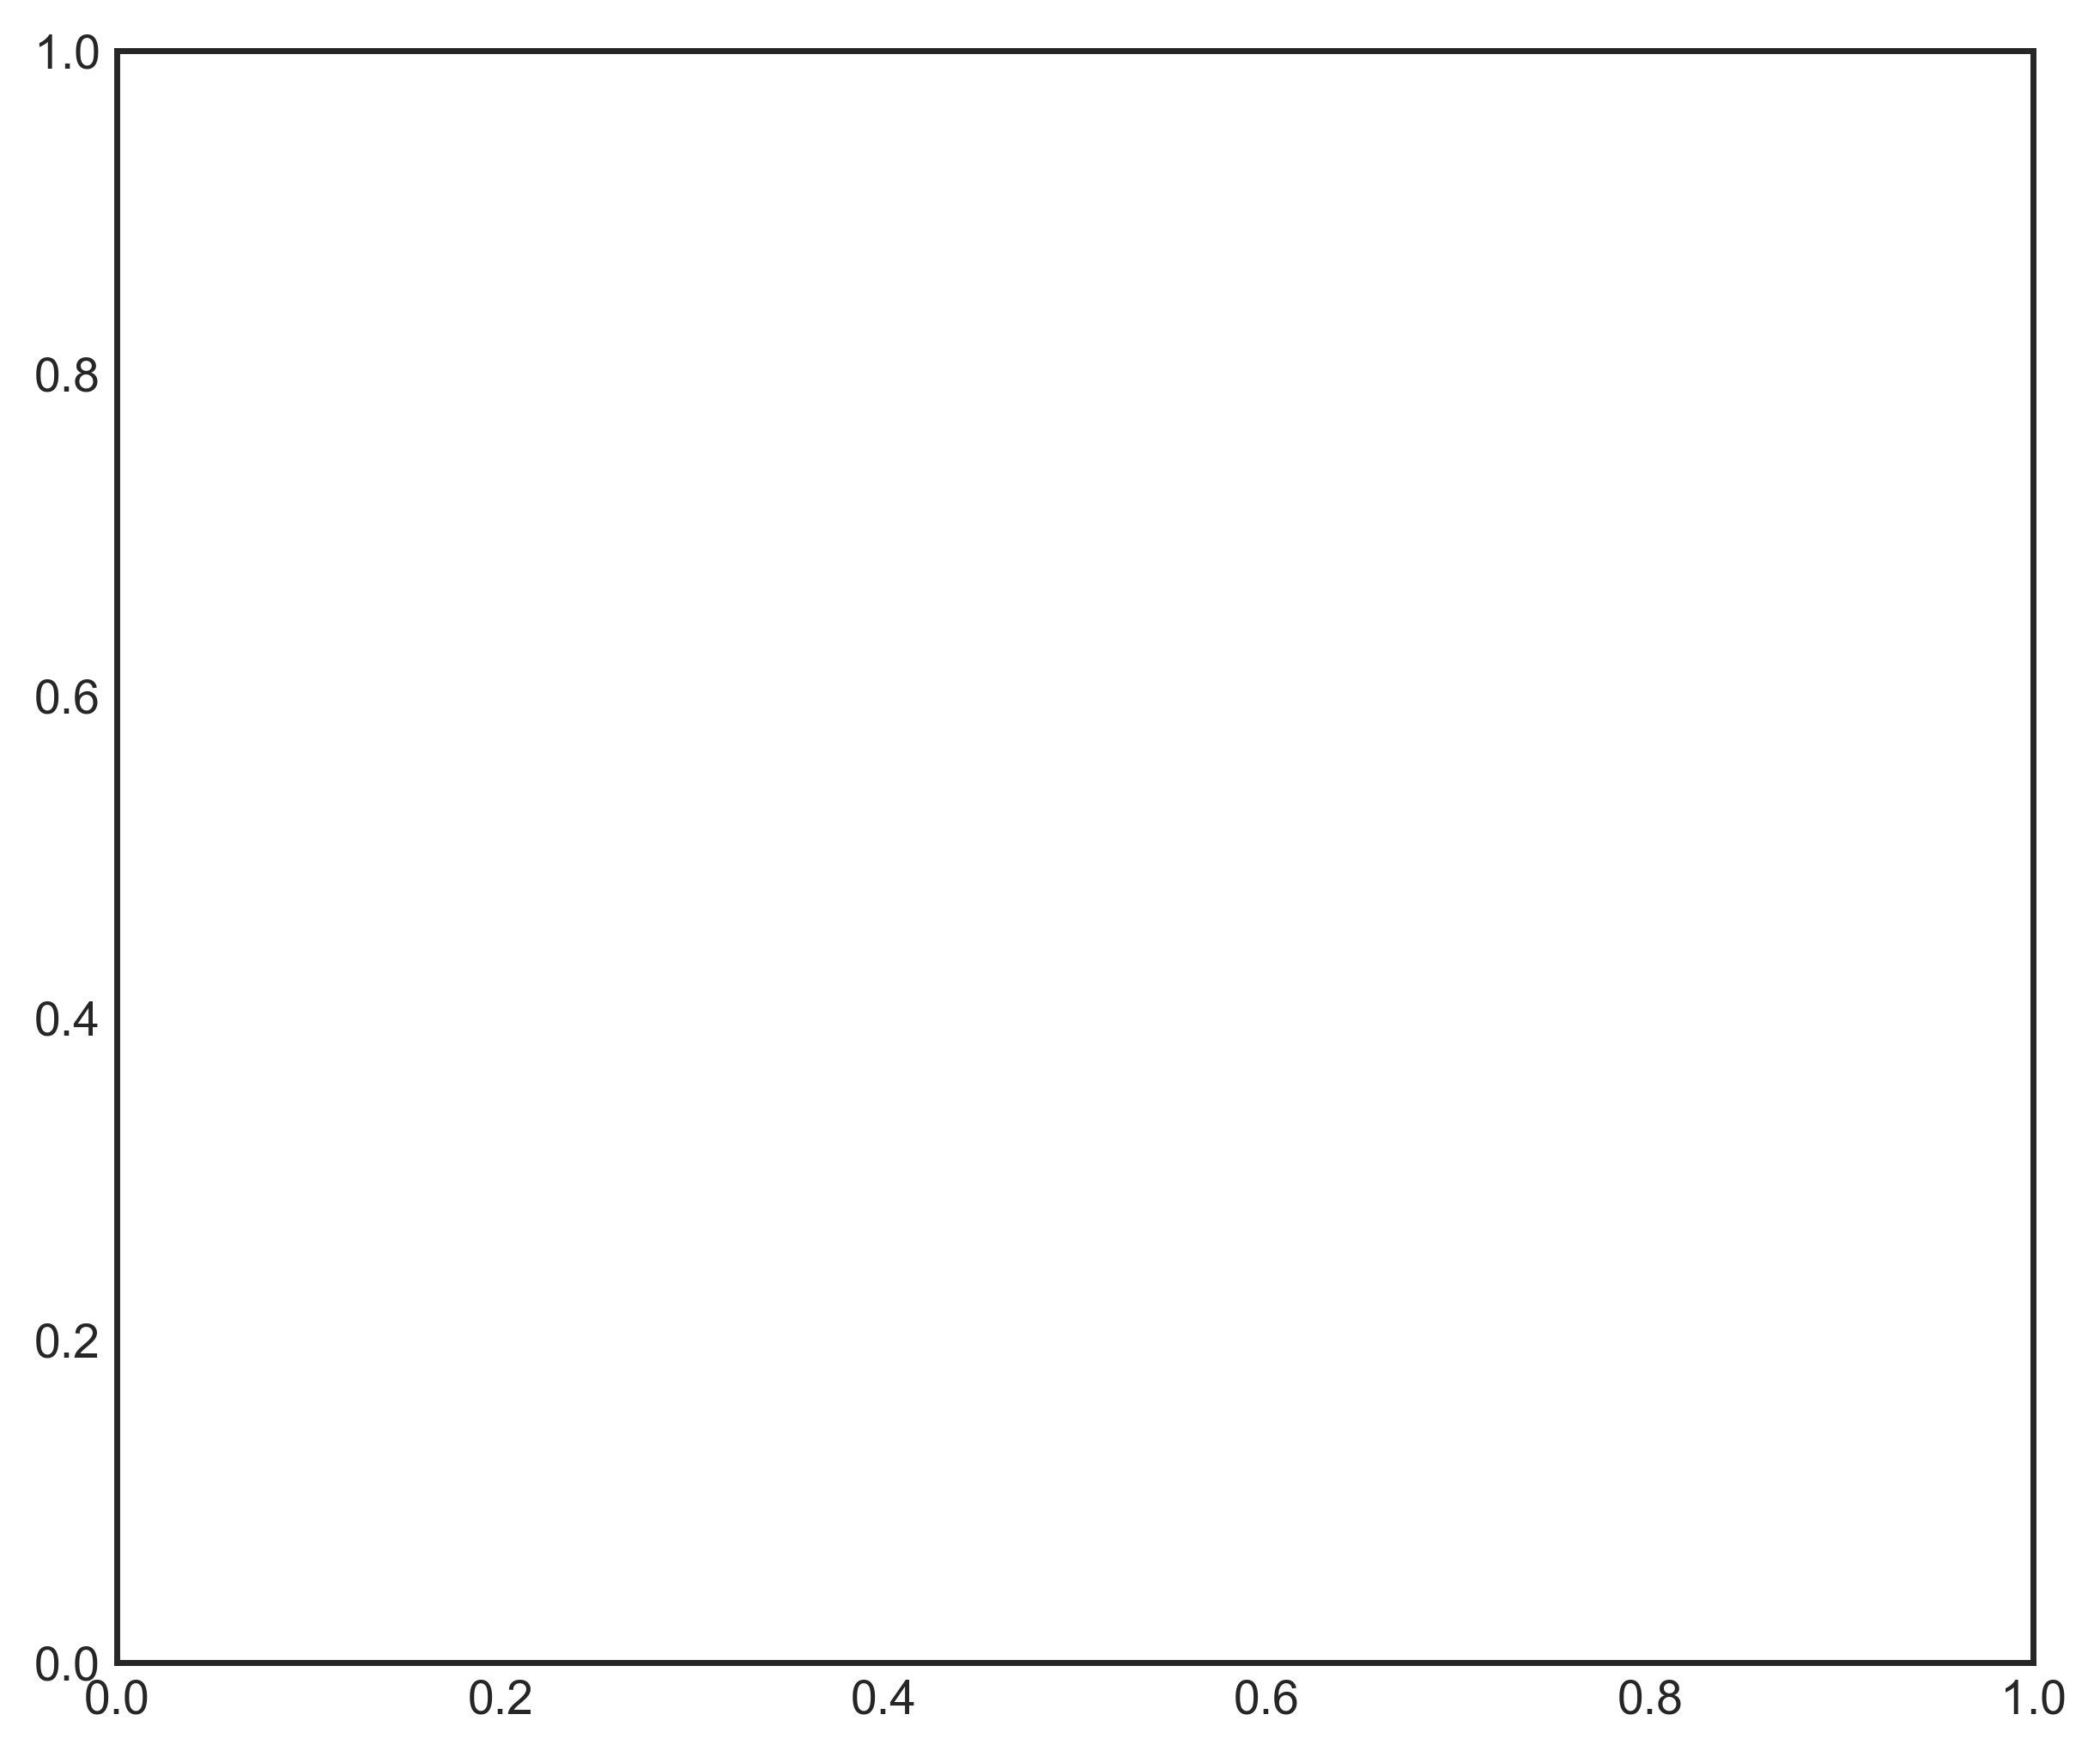

In [25]:
number_elec = 184
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

xvals = np.linspace(-0.5, 1, 1500)


fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)

# Consonant
speech_onset_v = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "v"]['starts_y']
speech_onset_t = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "t"]['starts_y']
speech_onset_s = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "s"]['starts_y']
speech_onset_g = subj_df_cue_speech[subj_df_cue_speech['stim_y'] == "gh"]['starts_y']

spike_mat_v = get_df(speech_onset_v, neural_df, timing, after=1, before=0.5)
mean_v = np.nanmean(spike_mat_v, axis=0)
sem_v = nansem(spike_mat_v, axis=0)
axs.plot(xvals, mean_v, 'r', alpha=0.6, label='v')
axs.fill_between(xvals, mean_v-sem_v, mean_v+sem_v, color='r', alpha=0.4)

spike_mat_t = get_df(speech_onset_t, neural_df, timing, after=1, before=0.5)
mean_t = np.nanmean(spike_mat_t, axis=0)
sem_t = nansem(spike_mat_t, axis=0)
axs.plot(xvals, mean_t, 'g', alpha=0.6, label='t')
axs.fill_between(xvals, mean_t-sem_t, mean_t+sem_t, color='g', alpha=0.4)

spike_mat_s = get_df(speech_onset_s, neural_df, timing, after=1, before=0.5)
mean_s = np.nanmean(spike_mat_s, axis=0)
sem_s = nansem(spike_mat_s, axis=0)
axs.plot(xvals, mean_s, 'b', alpha=0.6, label='s')
axs.fill_between(xvals, mean_s-sem_s, mean_s+sem_s, color='b', alpha=0.4)

spike_mat_g = get_df(speech_onset_g, neural_df, timing, after=1, before=0.5)
mean_g = np.nanmean(spike_mat_g, axis=0)
sem_g = nansem(spike_mat_g, axis=0)
axs.plot(xvals, mean_g, 'grey', alpha=0.6, label='g')
axs.fill_between(xvals, mean_g-sem_g, mean_g+sem_g, color='grey', alpha=0.4)

axs.axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs.axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
axs.set_xlabel("Time (s)", fontsize=25)
axs.set_ylabel("Firing rate (Hz)", fontsize=25)
axs.set_title("Consonant encoding unit", fontsize=30)
axs.set_xticklabels([round(item, 2) for item in axs.get_xticks()], fontsize=25, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
axs.legend(frameon=0, fontsize=25);
#axs.legend(frameon=0, fontsize=20, ncol=2, markerscale=0.1, bbox_to_anchor=(0.5, 0.42), 
#           labelspacing=0.1, columnspacing=0.2, numpoints=0.1);

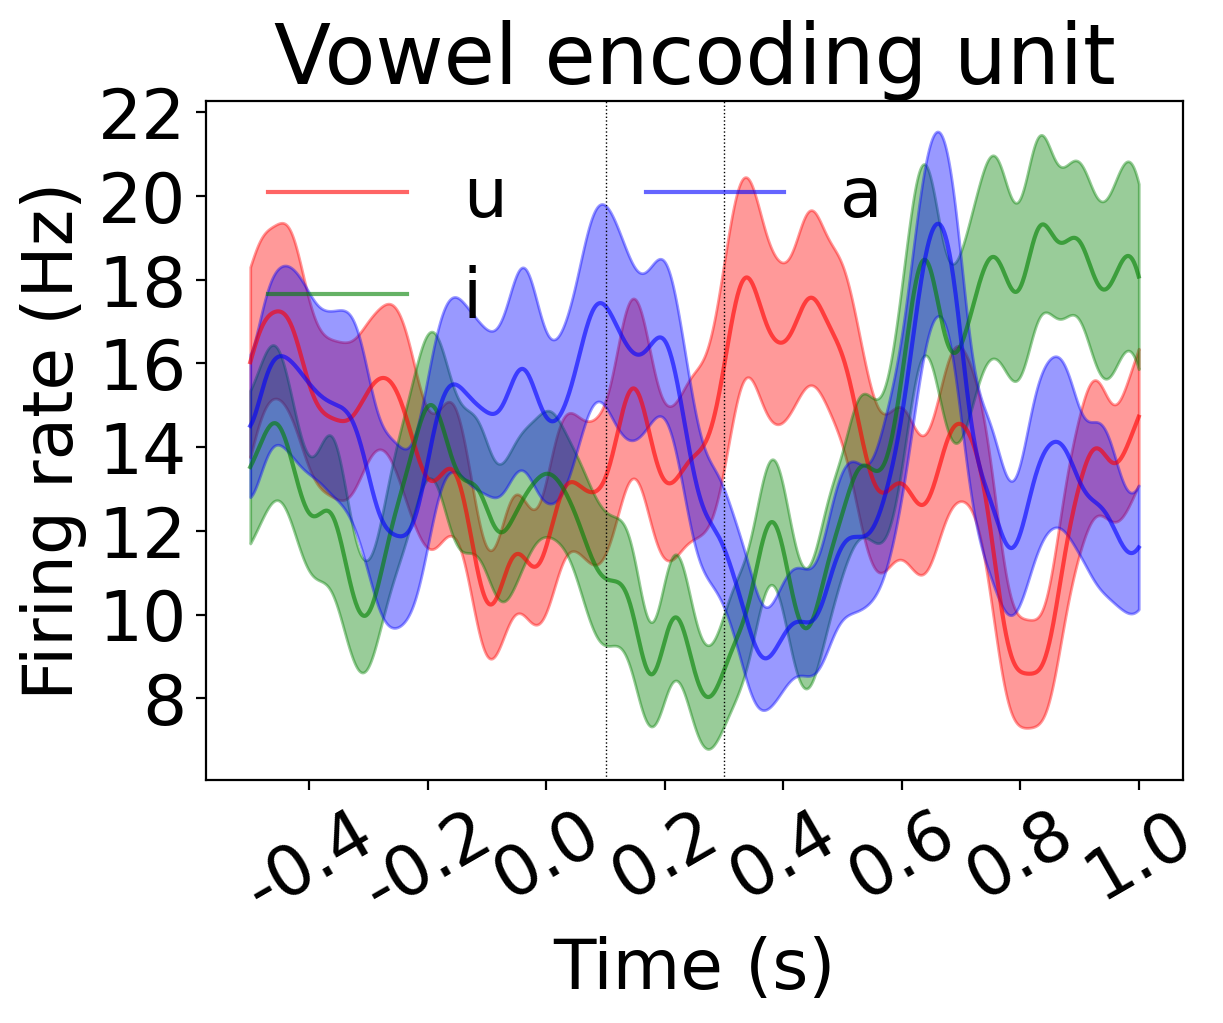

In [108]:
number_elec = 30
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

xvals = np.linspace(-0.5, 1, 1500)


fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)

# Vowel
speech_onset_u = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "oo"]['starts_y']
speech_onset_i = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "ee"]['starts_y']
speech_onset_a = subj_df_cue_speech[subj_df_cue_speech['stim_x'] == "ah"]['starts_y']

spike_mat_u = get_df(speech_onset_u, neural_df, timing, after=1, before=0.5)
mean_u = np.nanmean(spike_mat_u, axis=0)
sem_u = nansem(spike_mat_u, axis=0)
axs.plot(xvals, mean_u, 'r', alpha=0.6, label='u')
axs.fill_between(xvals, mean_u-sem_u, mean_u+sem_u, color='r', alpha=0.4)

spike_mat_i = get_df(speech_onset_i, neural_df, timing, after=1, before=0.5)
mean_i = np.nanmean(spike_mat_i, axis=0)
sem_i = nansem(spike_mat_i, axis=0)
axs.plot(xvals, mean_i, 'g', alpha=0.6, label='i')
axs.fill_between(xvals, mean_i-sem_i, mean_i+sem_i, color='g', alpha=0.4)

spike_mat_a = get_df(speech_onset_a, neural_df, timing, after=1, before=0.5)
mean_a = np.nanmean(spike_mat_a, axis=0)
sem_a = nansem(spike_mat_a, axis=0)
axs.plot(xvals, mean_a, 'b', alpha=0.6, label='a')
axs.fill_between(xvals, mean_a-sem_a, mean_a+sem_a, color='b', alpha=0.4)

axs.axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs.axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
axs.set_xlabel("Time (s)", fontsize=25)
axs.set_ylabel("Firing rate (Hz)", fontsize=25)
axs.set_title("Vowel encoding unit", fontsize=30)
axs.set_xticklabels([round(item, 2) for item in axs.get_xticks()], fontsize=25, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
axs.legend(frameon=0, fontsize=25, ncol=2);
#axs.legend(frameon=0, fontsize=20, ncol=3, markerscale=0.1, bbox_to_anchor=(0.7, 0.6), 
#           labelspacing=0.1, columnspacing=0.2, numpoints=0.1);

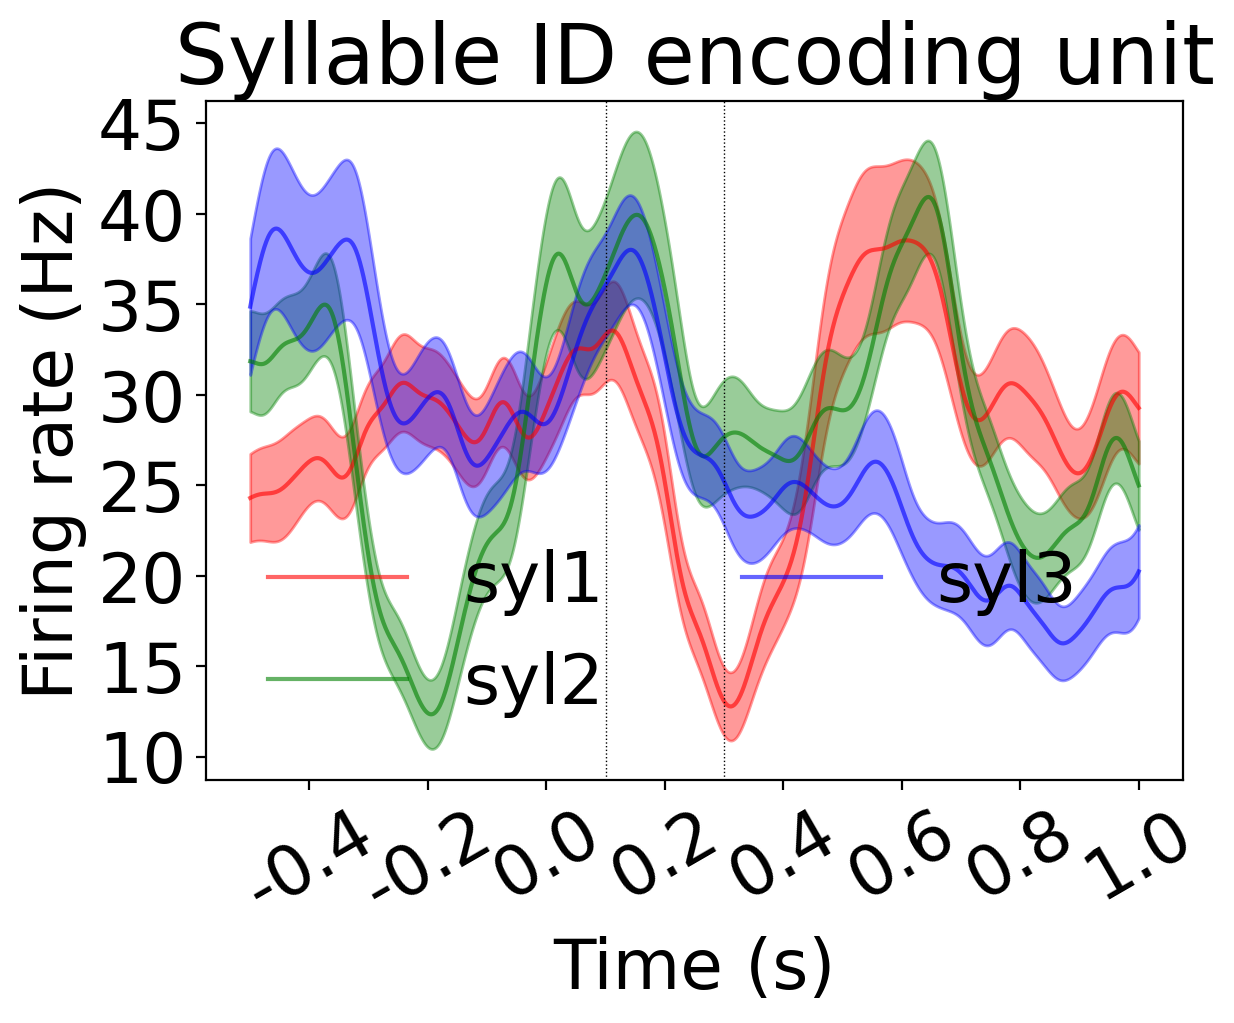

In [15]:
number_elec = 26
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

xvals = np.linspace(-0.5, 1, 1500)


fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)

# Syl ID
speech_onset_1 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 1]['starts_y']
speech_onset_2 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 2]['starts_y']
speech_onset_3 = subj_df_cue_speech[subj_df_cue_speech['syl_id'] == 3]['starts_y']

spike_mat_1 = get_df(speech_onset_1, neural_df, timing, after=1, before=0.5)
mean_1 = np.nanmean(spike_mat_1, axis=0)
sem_1 = nansem(spike_mat_1, axis=0)
axs.plot(xvals, mean_1, 'r', alpha=0.6, label='syl1')
axs.fill_between(xvals, mean_1-sem_1, mean_1+sem_1, color='r', alpha=0.4)

spike_mat_2 = get_df(speech_onset_2, neural_df, timing, after=1, before=0.5)
mean_2 = np.nanmean(spike_mat_2, axis=0)
sem_2 = nansem(spike_mat_2, axis=0)
axs.plot(xvals, mean_2, 'g', alpha=0.6, label='syl2')
axs.fill_between(xvals, mean_2-sem_2, mean_2+sem_2, color='g', alpha=0.4)

spike_mat_3 = get_df(speech_onset_3, neural_df, timing, after=1, before=0.5)
mean_3 = np.nanmean(spike_mat_3, axis=0)
sem_3 = nansem(spike_mat_3, axis=0)
axs.plot(xvals, mean_3, 'b', alpha=0.6, label='syl3')
axs.fill_between(xvals, mean_3-sem_3, mean_3+sem_3, color='b', alpha=0.4)

axs.axvline(0.1, color='k', linewidth=0.5, linestyle='dotted')
axs.axvline(0.3, color='k', linewidth=0.5, linestyle='dotted')
axs.set_xlabel("Time (s)", fontsize=25)
axs.set_ylabel("Firing rate (Hz)", fontsize=25)
axs.set_title("Syllable ID encoding unit", fontsize=30)
axs.set_xticklabels([round(item, 2) for item in axs.get_xticks()], fontsize=25, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
axs.legend(frameon=0, fontsize=25, ncol=2);

#axs.legend(frameon=0, fontsize=20, ncol=2, markerscale=0.1, bbox_to_anchor=(0.41, 0.6), 
#           labelspacing=0.1, columnspacing=0.2, numpoints=0.1);

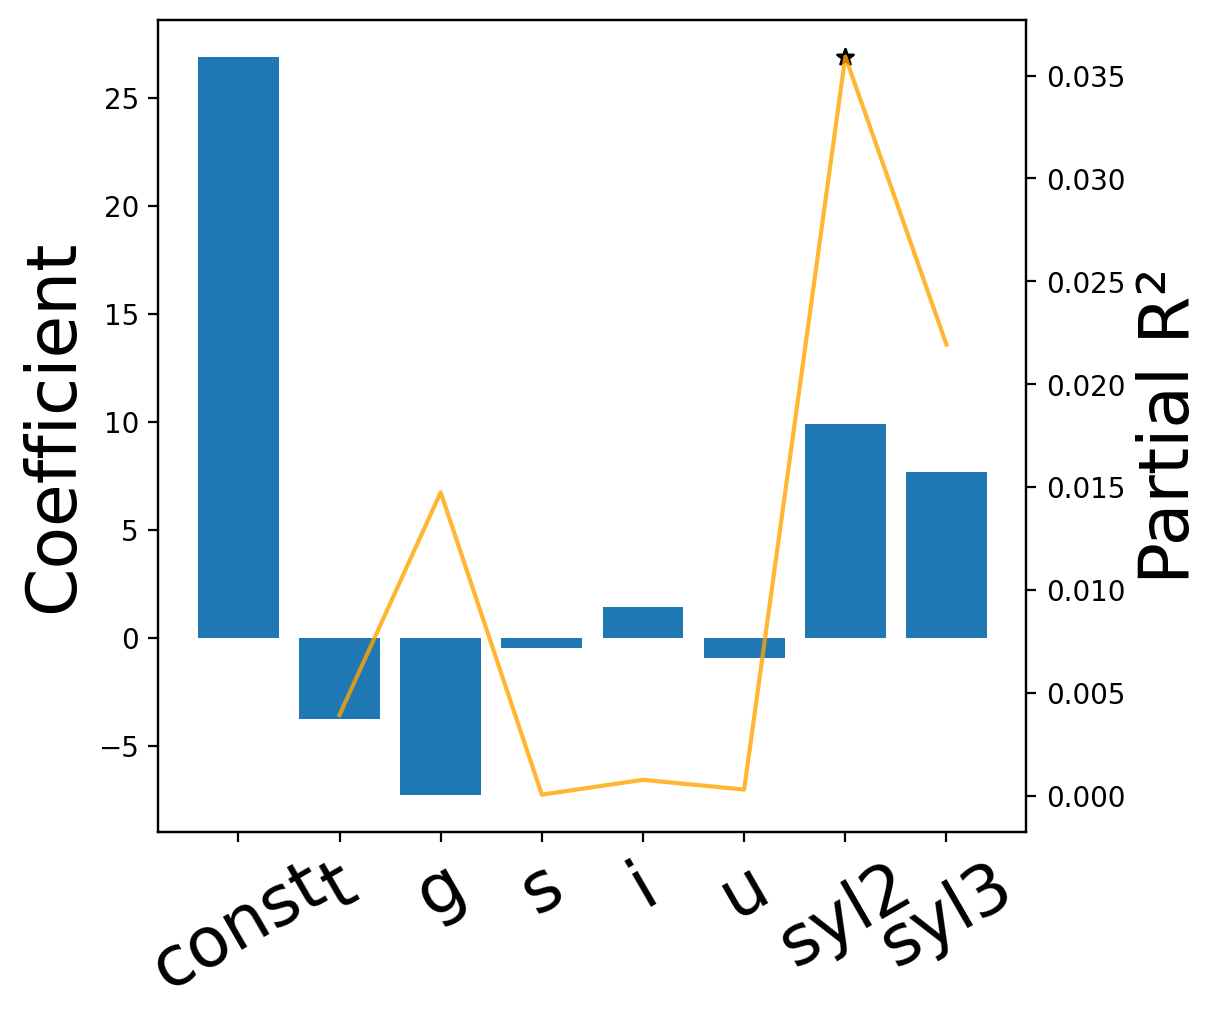

In [13]:
number_elec = 26
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1))
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1))
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1))
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1))
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1))
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1))
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1))
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)
axs.bar(x=model_full.index, height=model_full['coef'])

ax2 = axs.twinx()
ax2.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k')
axs.set_ylabel("Coefficient", fontsize=25)
ax2.set_ylabel(f"Partial R{get_super('2')}", fontsize=25)
axs.set_xticklabels(model_full.index, rotation=30, fontsize=25);


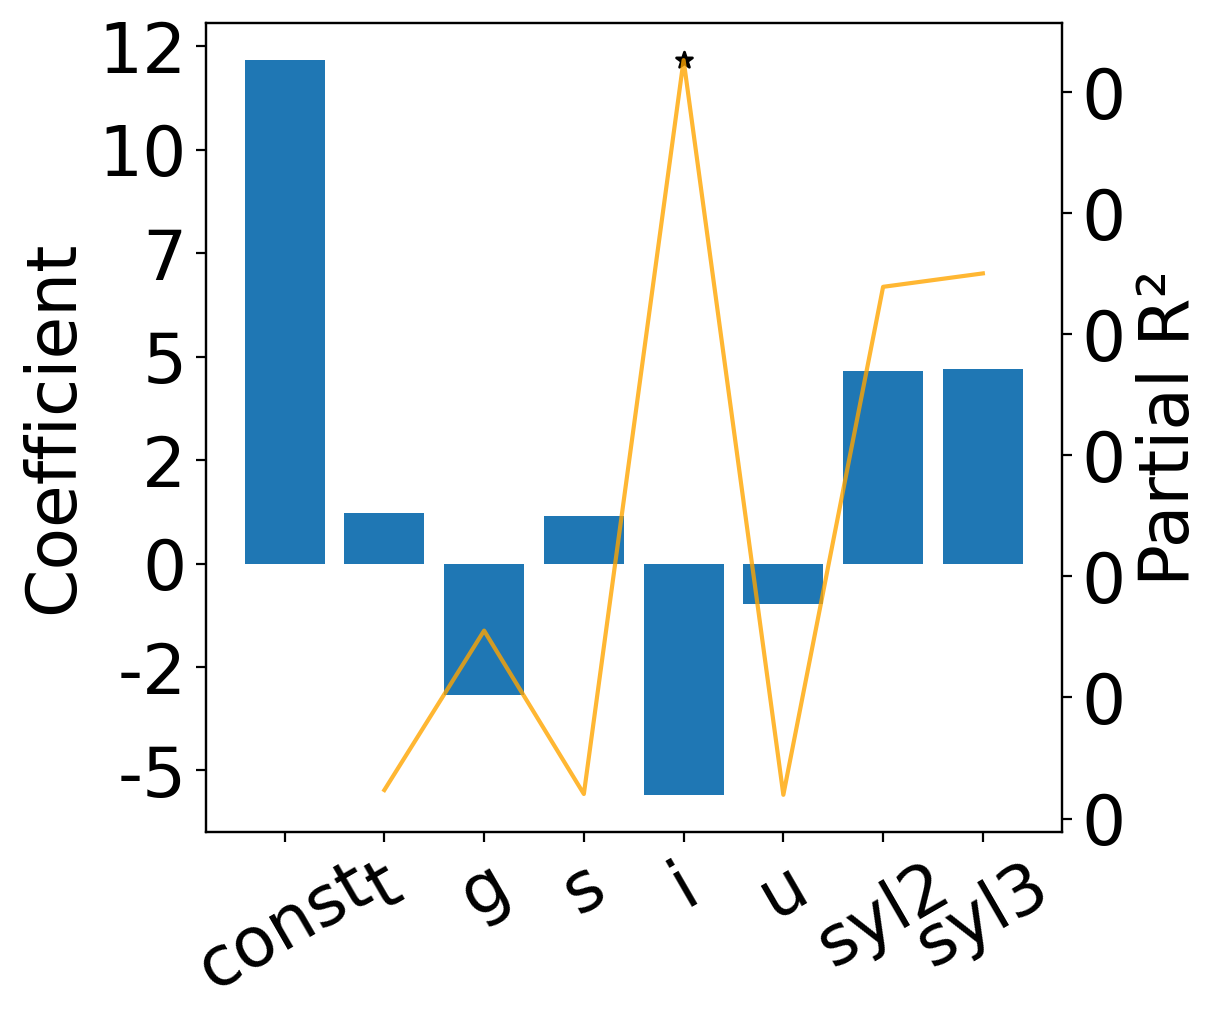

In [12]:
number_elec = 30
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1))
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1))
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1))
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1))
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1))
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1))
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1))
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)
axs.bar(x=model_full.index, height=model_full['coef'])

ax2 = axs.twinx()
ax2.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k')
axs.set_ylabel("Coefficient", fontsize=25)
ax2.set_ylabel(f"Partial R{get_super('2')}", fontsize=25)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=25)
axs.set_xticklabels(model_full.index, rotation=30, fontsize=25);


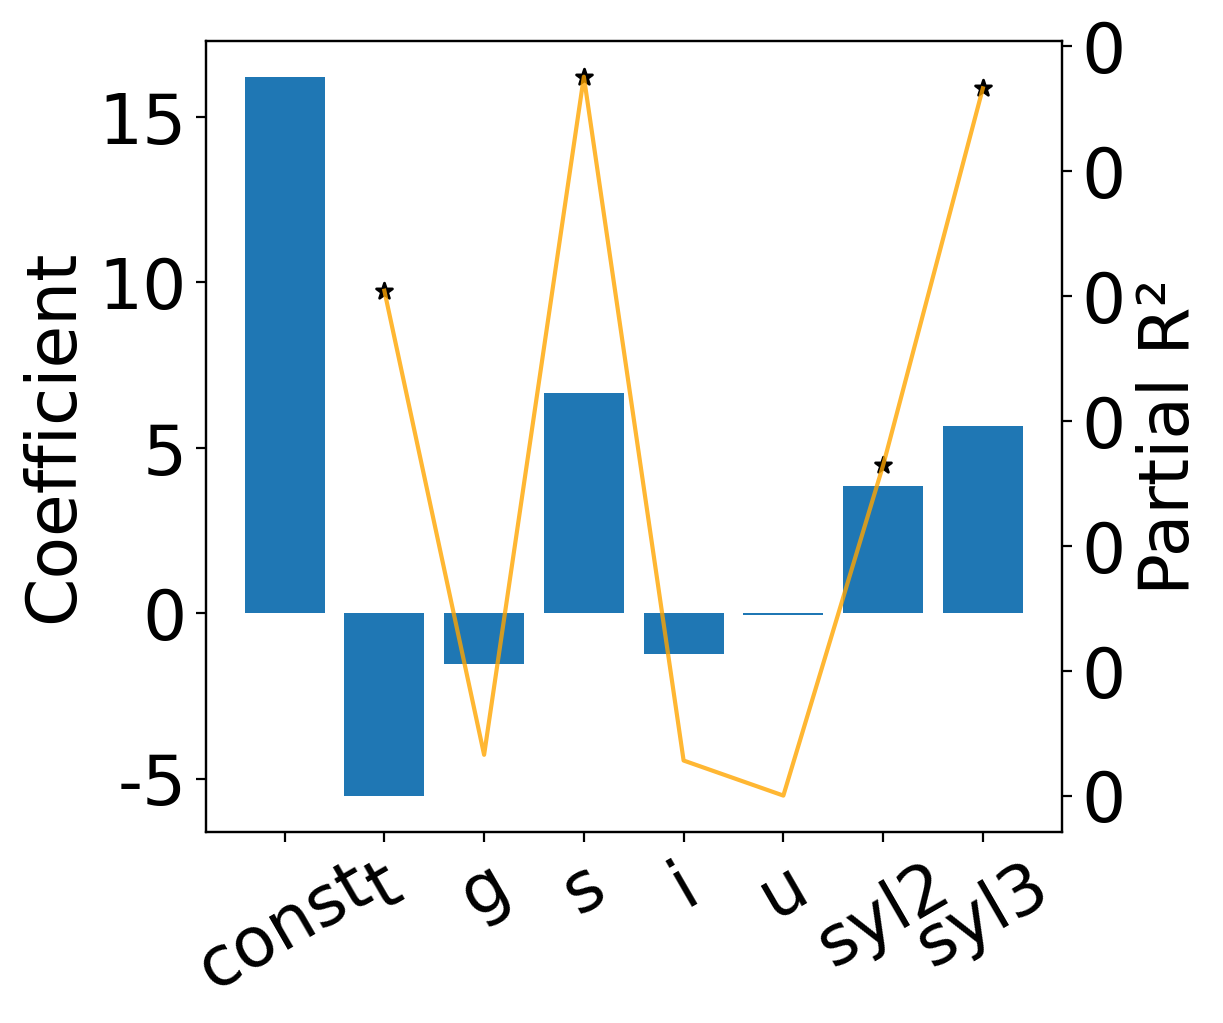

In [13]:
number_elec = 184
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

regression_para = get_matrix2(subj_df_cue_speech, neural_df, timing)

sse_full, model_full = get_model_result(regression_para)
model_full['pR2'] = 0.

sse_t, _ = get_model_result(regression_para.drop('t', axis=1))
model_full['pR2']['t'] = (sse_t - sse_full)/sse_t

sse_g, _ = get_model_result(regression_para.drop('g', axis=1))
model_full['pR2']['g'] = (sse_g - sse_full)/sse_g

sse_s, _ = get_model_result(regression_para.drop('s', axis=1))
model_full['pR2']['s'] = (sse_s - sse_full)/sse_s

sse_i, _ = get_model_result(regression_para.drop('i', axis=1))
model_full['pR2']['i'] = (sse_i - sse_full)/sse_i

sse_u, _ = get_model_result(regression_para.drop('u', axis=1))
model_full['pR2']['u'] = (sse_u - sse_full)/sse_u

sse_2, _ = get_model_result(regression_para.drop('syl2', axis=1))
model_full['pR2']['syl2'] = (sse_2 - sse_full)/sse_2

sse_3, _ = get_model_result(regression_para.drop('syl3', axis=1))
model_full['pR2']['syl3'] = (sse_3 - sse_full)/sse_3

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)
axs.bar(x=model_full.index, height=model_full['coef'])

ax2 = axs.twinx()
ax2.plot(range(1, 8), model_full['pR2'][1:], color='orange', alpha=0.8)

for item in range(1, model_full.shape[0]):
    if model_full['sig'][item] == 1:
        ax2.scatter(x=item, y=model_full['pR2'][item], marker="*", color='k')
axs.set_ylabel("Coefficient", fontsize=25)
ax2.set_ylabel(f"Partial R{get_super('2')}", fontsize=25)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=25)
axs.set_xticklabels(model_full.index, rotation=30, fontsize=25);
